In [3]:
import xarray as xr
# import matplotlib.pyplot as plt
import datetime
from glob import glob
import dask, dask.distributed
import dask_jobqueue
import matplotlib.pyplot as plt
import datetime
import numpy as np
# import parcels
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import cartopy.crs as ccrs
import cmocean
from xhistogram.xarray import histogram as xhist

In [6]:
entire_times = pd.date_range(start="2020-05-31", end="1993-01-01", freq="-12H")


In [7]:
entire_times

DatetimeIndex(['2020-05-31 00:00:00', '2020-05-30 12:00:00',
               '2020-05-30 00:00:00', '2020-05-29 12:00:00',
               '2020-05-29 00:00:00', '2020-05-28 12:00:00',
               '2020-05-28 00:00:00', '2020-05-27 12:00:00',
               '2020-05-27 00:00:00', '2020-05-26 12:00:00',
               ...
               '1993-01-05 12:00:00', '1993-01-05 00:00:00',
               '1993-01-04 12:00:00', '1993-01-04 00:00:00',
               '1993-01-03 12:00:00', '1993-01-03 00:00:00',
               '1993-01-02 12:00:00', '1993-01-02 00:00:00',
               '1993-01-01 12:00:00', '1993-01-01 00:00:00'],
              dtype='datetime64[ns]', length=20025, freq='-12h')

In [9]:
ds=xr.open_dataset('../data/level1/parcels_releases_seed-2345_2020053100-2020053100.zarr',engine='zarr')

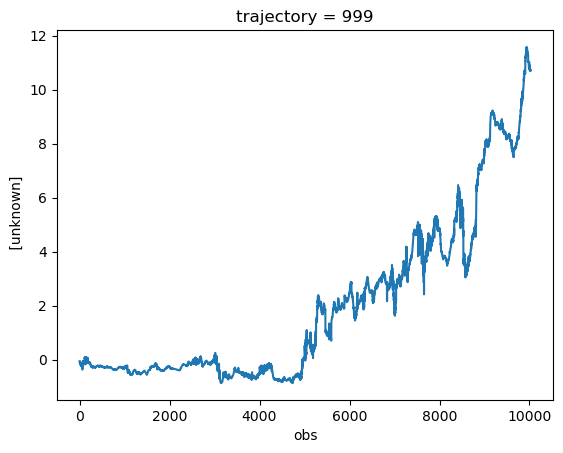

In [11]:
ds.isel(trajectory=-1).temp.plot();

In [2]:
ds=xr.open_dataset('data/level2/retry_with_time_parcels_releases_seed-2345.zarr',engine='zarr') #, chunks={}

In [8]:
ds.isel(trajectory=-393).time#emp.plot();

<xarray.DataArray 'time' (time: 20025)>
array(['2020-05-31T00:00:00.000000000', '2020-05-30T12:00:00.000000000',
       '2020-05-30T00:00:00.000000000', ..., '1993-01-02T00:00:00.000000000',
       '1993-01-01T12:00:00.000000000', '1993-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time        (time) datetime64[ns] 2020-05-31 ... 1993-01-01
    trajectory  int64 3517727

In [2]:
cluster = dask_jobqueue.SLURMCluster(

    # Dask worker size
    cores=4, memory='16GB',
    processes=1, # Dask workers per job
    
    # SLURM job script things
    queue='base', walltime='04:00:00',
    
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',  # for spilling tmp data to disk
    log_directory='slurm/' 
)

client = dask.distributed.Client(cluster)

cluster.scale(jobs=15) #15
client

<Client: 'tcp://172.18.4.23:39409' processes=0 threads=0, memory=0 B>

In [2]:
#ds = xr.open_dataset('data/level2/with_time_parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto') #with_time_parcels_releases_seed-2345.zarr
# parcels_releases_seed-2345.zarr

In [4]:
ds = xr.open_dataset('data/level2/parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto')




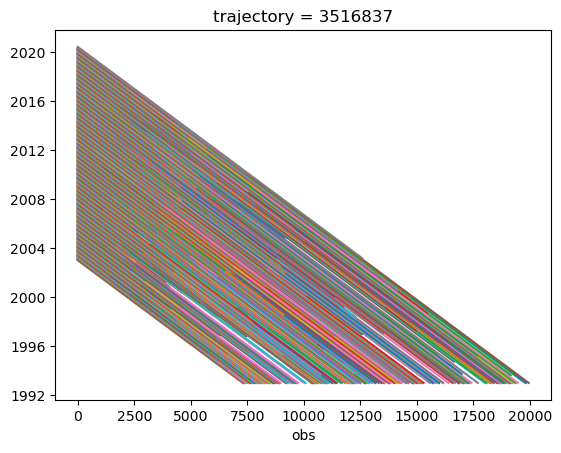

In [6]:
for i in np.arange(0,ds.trajectory.size,1000):
    ds.isel(trajectory=i).time.plot()
plt.show()

In [7]:
# # checks if difference is positive in lon and lat
# particle_moves = (ds.lon.diff('obs') > 0) & ((ds.lat.diff('obs') > 0))

# # checks if there is any movement (True) along the obs dimension, where ~negates, so particle never moves
# # is true when particles never move 
# particle_never_moves = ~particle_moves.any('obs')

# # checjs values where particles moves 
# particle_always_moves = particle_moves.all('obs')

# # filters ds_always moves when particles always move, drop = False does not drop the dimensions -- all lazily computed
# ds_always_moves = ds.where(particle_always_moves, drop=False) # False

# ds_at_least_not_stuck_at_all_times = ds.where(~particle_never_moves)

In [3]:
# USE SALINITY AS indicator of trajectories that crash into land


# Find particles where salinity reaches 0 at any observation point
particles_reach_zero_salinity = (ds.salt == 0).any('time')

particles_beached = ~particles_reach_zero_salinity

# Filter the dataset to include only particles that reach zero salinity
ds_particles_reach_zero_salinity_beached = ds.where(particles_beached, drop=False)


12350010002000300040001000050000100000200000300000400000497700

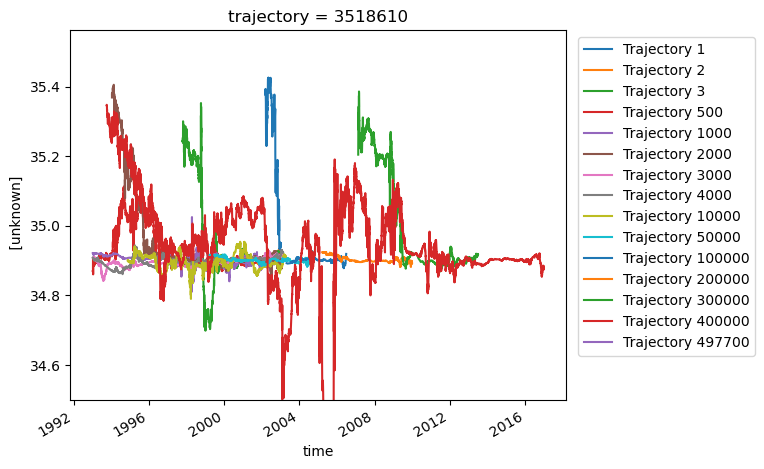

In [10]:
for i in np.array([1, 2, 3, 500, 1000, 2000, 3000, 4000, 10000, 50000, 100000, 200000, 300000, 400000, 497700]):
    print(i,end='')
    ds_particles_reach_zero_salinity_beached.salt.isel(trajectory=i).plot(label=f'Trajectory {i}')
plt.legend(bbox_to_anchor=(1.01, 1))
plt.ylim(34.5,None)
plt.show()

In [4]:
ds_filter = ds_particles_reach_zero_salinity_beached

In [5]:
ds = ds_filter

In [6]:
# compute density

import seawater as gsw

ds_density = xr.apply_ufunc(gsw.eos80.pden,ds.salt,ds.temp,0,dask='parallelized',output_dtypes=[np.float64]) - 1000

In [7]:
# assigning density to the ds!! 
ds_add_dens = ds.assign(sigma0=ds_density)

In [8]:
ds = ds_add_dens

In [15]:
# def find_last_valid_time(ds_filter, traj_num):
#     time_values = ds_filter.time.isel(trajectory=traj_num).values

#     # Find the last index that is not NaT
#     last_valid_index = np.where(~np.isnan(time_values))[0][-1]
#     last_valid_time = time_values[last_valid_index]

#     return last_valid_time, last_valid_index

# last_valid_time = find_last_valid_time(ds_filter, 25)
# print("Last valid time step:", last_valid_time[0], '. Index:', last_valid_time[1])

In [18]:
# see how many particles are moving and then beaching but using only one variable to reduce time it takes to load 

ds_filter_slice = ds_filter.isel(trajectory=slice(0,45))

test = ds_filter_slice.salt.sum(dim='time')#.where(ds_filter_slice.sum(dim='obs') == 0, drop=True).compute()

In [19]:
# Compute the boolean indexer first
indexer = (ds_filter_slice.salt.sum(dim='time') == 0).compute()

# Use the computed indexer for indexing
sel_slice = ds_filter_slice.where(~indexer, drop=True)

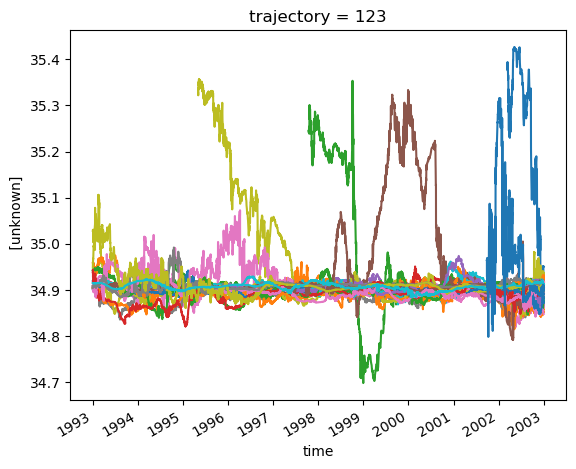

In [20]:
for i in range(sel_slice.trajectory.size):
    sel_slice.salt.isel(trajectory=i).plot(label=f'Trajectory {i}')
plt.show()

In [22]:
test = ds_filter.salt.sum(dim='time')#.where(ds_filter_slice.sum(dim='obs') == 0, drop=True).compute()

# # Compute the boolean indexer first
indexer = (ds_filter.salt.sum(dim='time') == 0).compute()

# Use the computed indexer for indexing
print('percentage of beached particles =', 
      ((ds_filter.trajectory.size - test.where(~indexer, drop=True).trajectory.size)/ds_filter.trajectory.size)*100, '%')


percentage of beached particles = 4.050082070466083 %


In [28]:
# test = ds_filter.salt.sum(dim='obs')#.where(ds_filter_slice.sum(dim='obs') == 0, drop=True).compute()

# # # Compute the boolean indexer first
# indexer = (ds_filter.salt.sum(dim='obs') == 0).compute()

# # Use the computed indexer for indexing
# print('percentage of beached particles =', 
#       ((ds_filter.trajectory.size - test.where(~indexer, drop=True).trajectory.size)/ds_filter.trajectory.size)*100, '%')


In [27]:
#ds

In [9]:
# load in snapshot velocity and mesh masks

U_snapshot = xr.open_dataset('../../Data/U/U_velocity_2010-06-30.nc')
V_snapshot = xr.open_dataset('../../Data/V/V_velocity_2010-06-30.nc')

m = 1#650
U_m = U_snapshot.vozocrtx.isel(time_counter=0).sel(deptht=m,method='nearest')
V_m = V_snapshot.vomecrty.isel(time_counter=0).sel(deptht=m,method='nearest')

speed_m = (U_m**2 + V_m**2)**.5

mesh_mask = xr.open_dataset('../../Data/mesh_masks/mesh_mask.nc')
mesh_hzgr = xr.open_dataset('../../Data/mesh_masks/mesh_hzgr.nc')
mesh_hgr = xr.open_dataset('../../Data/mesh_masks/mesh_hgr.nc')

z = mesh_hzgr.e3t_0
t_mask = mesh_mask.tmask

# bathymetry (Depth level) at every grid point 
bathymetry = (z*t_mask).isel(t=0).sum(dim='z')

# turn zeros into nans, easier to see where continents are 
bath_total_nans = bathymetry.where(bathymetry != 0)


In [13]:
# np.arange(0, ds_filter.trajectory.size, 30_000) 

#V_snapshot.vomecrty.isel(time_counter=0).sel(deptht=1100,method='nearest').plot(vmin=-.1,vmax=.1, cmap='RdBu_r')

012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849

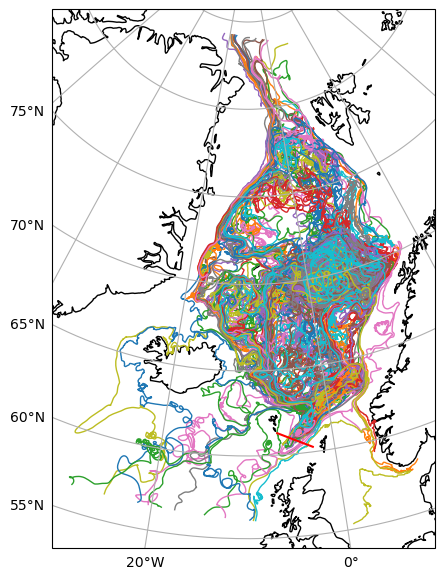

In [14]:
import matplotlib.colors as mcolors
# Assuming mesh_mask, speed_m, lon_ds_filter, and lat_ds_filter are already defined

# Create a figure with an orthographic projection
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))


# Loop through the trajectories and plot them
i = np.arange(0, ds_filter.trajectory.size, 10_000) #np.arange(ds_filter.trajectory.size) #
colors = list(mcolors.TABLEAU_COLORS.values())
for idx, index in enumerate(i):
    print(idx,end='')
    # Use plt.plot to connect the points with a line
    ax.plot(
        ds_filter.lon.isel(trajectory=index), 
        ds_filter.lat.isel(trajectory=index), 
        color=colors[idx % len(colors)], 
        linewidth=1,  # Adjust the line width here
        transform=ccrs.PlateCarree()
    )
plt.plot([-6.5,-2.5],[61.3,60.3],color='red', transform=ccrs.PlateCarree())
# Add coastlines
ax.coastlines()
# Add gridlines for longitude and latitude
gl = ax.gridlines(draw_labels=True,dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

#plt.savefig('particle_release',dpi=600,bbox_inches='tight',transparent=False)
plt.show()


In [38]:
# import pandas as pd
# times = pd.date_range('2020-05-01', '1993-01-01', freq='-1D')
# times


In [ ]:
# ds_filter.isel(trajectory=0).assign_coords(time=ds_filter.time.isel(trajectory=0))
#ds_filter.isel(trajectory=slice(0,3)).set_coords('time').reindex({'time':times, })

In [ ]:
# def create_sparse_dataset(ds, times):
#     """
#     Create a sparse dataset with dimension trajectory and time.
#     Time will have a lot of missing values as not all trajectories
#     cover the entire time span.

#     Using time(trajectory, obs) to get the time dimension.

#     Parameters
#     ----------
#     ds : xarray.Dataset
#         The dataset with the particle trajectories.
#     times : pd.DatetimeIndex
#         The time index to use for the new dataset covering entire parcels output.
#     """
#     new_ds = xr.Dataset(coords={'time': times, 'trajectory': ds.trajectory})
#     for var in ds.data_vars:
#         new_ds[var] = xr.DataArray(dims=('trajectory', 'time'), coords={'trajectory': ds.trajectory, 'time': times})
#     for traj in ds.trajectory:
#         # Get the time values for the trajectory
#         time_values = ds.time.sel(trajectory=traj)
#         # Create a new DataArray with the time values
#         traj_start_time = time_values.isel(obs=0)
#         traj_start_idx = np.argwhere(new_ds.time == traj_start_time)
#         for var in ds.data_vars:
#             new_ds[var][traj_start_idx:, traj] = ds[var].sel(trajectory=traj)
        
#     return new_ds
    


In [ ]:
import datetime as dt 

## assign a time to the start 
p=ds#.isel(trajectory=slice(0,1000,100))
p['start_time'] = p.isel(obs=0).time
p=p.set_coords('start_time')
p=p.set_xindex('start_time')


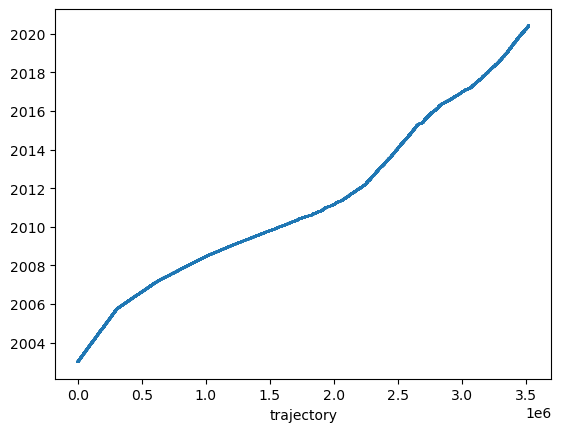

In [13]:
p.start_time.plot();

In [17]:
T_release = p.groupby('start_time').mean().temp.isel(obs=0, drop=True)

S_release = p.groupby('start_time').mean().salt.isel(obs=0, drop=True)

In [18]:
z_release = p.groupby('start_time').mean().z.isel(obs=0, drop=True)

In [19]:
vvel_release = p.groupby('start_time').mean().vvel.isel(obs=0, drop=True)

In [20]:
dens_release = p.groupby('start_time').mean().sigma0.isel(obs=0, drop=True)

In [28]:
dens_release_cp = dens_release.compute()

In [20]:
T_release_cp = T_release.compute()
S_release_cp = S_release.compute()

In [47]:
z_release_cp = z_release.compute()
vvel_release_cp = vvel_release.compute()

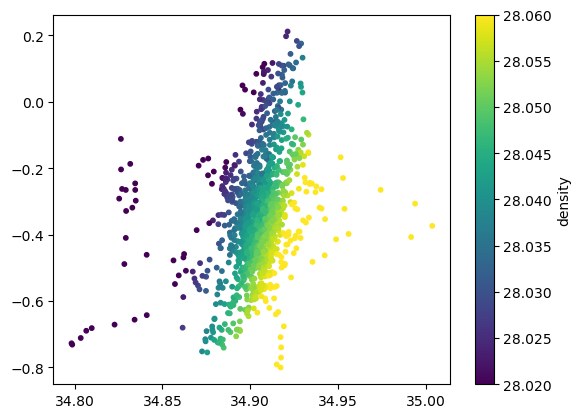

In [29]:
plt.scatter(S_release_cp, T_release_cp, c=dens_release_cp, s=10, 
            vmin=28.02,vmax=28.06,cmap='viridis')
cbar = plt.colorbar()
cbar.set_label('density')
plt.show()


In [46]:
def sigma_contour_grid(salinity, temp):
    S = salinity
    T = temp
    smin = S.min() - (0.05 * S.min())
    smax = S.max() + (0.05 * S.max())
    tmin = T.min() - (.5 * T.max()) #0.2
    tmax = T.max() + (.5 * T.max())
    tempL=np.linspace(tmin,tmax,200) #400
    salL=np.linspace(smin,smax,200) #400
    Sg,Tg = np.meshgrid(salL,tempL)

    # sigma contour lines references to surface 
    sigma_theta = gsw.eos80.pden(Sg,Tg,0) - 1000
    return Sg, Tg, sigma_theta, S, T

In [47]:
sigma_contour_release = sigma_contour_grid(S_release_cp, T_release_cp)

In [51]:
# plt.contour(sigma_contour_release[0], sigma_contour_release[1], sigma_contour_release[2], levels=np.arange(28.0, 28.1, 0.01), colors='k', alpha=0.5)
# plt.xlim(34.8, 35)
# plt.show()

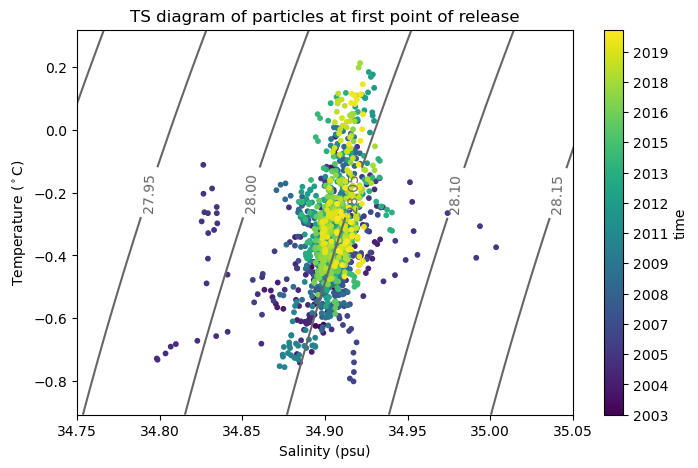

In [53]:
import pandas as pd
plt.figure(figsize=(8, 5))

# Convert datetime to int64 for color mapping
c_values = T_release_cp['start_time'].values.astype(np.int64)

# Scatter plot
scatter = plt.scatter(S_release_cp, T_release_cp, 
                      c=c_values, s=10, cmap='viridis')
cbar = plt.colorbar(scatter)
cbar.set_label('time')

# Format the colorbar ticks to show dates
tick_interval = 100  # Adjust this value to change the frequency of ticks
tick_positions = c_values[::tick_interval] 
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(pd.to_datetime(tick_positions).strftime('%Y'))

# Sg, Tg, sigma_theta, S, T = sigma_contour_grid(S_release_cp, T_release_cp)
# contour = plt.contour(Sg, Tg, sigma_theta, colors='black', linewidths=0.5)
# plt.clabel(contour, fmt='%1.1f', fontsize=8)
manual_locations = [(34.9, -0.2)]
for level in np.arange(27.7, 28.5, 0.05):
    CS = plt.contour(sigma_contour_release[0], sigma_contour_release[1], sigma_contour_release[2], [level], cmap='Dark2_r') 
    plt.clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)
plt.xlim(34.75, 35.05)
plt.xlabel('Salinity (psu)')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('TS diagram of particles at first point of release')
plt.show()


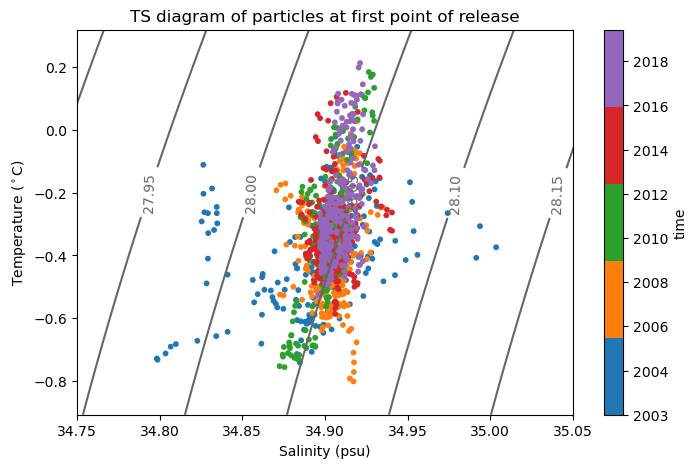

In [184]:
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

plt.figure(figsize=(8, 5))

# Convert datetime to int64 for color mapping
c_values = T_release_cp['start_time'].values.astype(np.int64)

# Define a colormap with different colors for each 5-year interval
cmap = mcolors.ListedColormap(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'])

# Scatter plot
scatter = plt.scatter(S_release_cp, T_release_cp, 
                      c=c_values, s=10, cmap=cmap)
cbar = plt.colorbar(scatter)
cbar.set_label('time')

# Format the colorbar ticks to show dates
tick_interval = 2 * 365 * 24 * 60 * 60 * 10**9  # 5 years in nanoseconds
tick_positions = np.arange(c_values.min(), c_values.max(), tick_interval)
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(pd.to_datetime(tick_positions).strftime('%Y'))

manual_locations = [(34.9, -0.2)]
for level in np.arange(27.7, 28.5, 0.05):
    CS = plt.contour(sigma_contour_release[0], sigma_contour_release[1], sigma_contour_release[2], [level], cmap='Dark2_r') 
    plt.clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)
plt.xlim(34.75, 35.05)
plt.xlabel('Salinity (psu)')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('TS diagram of particles at first point of release')
plt.show()


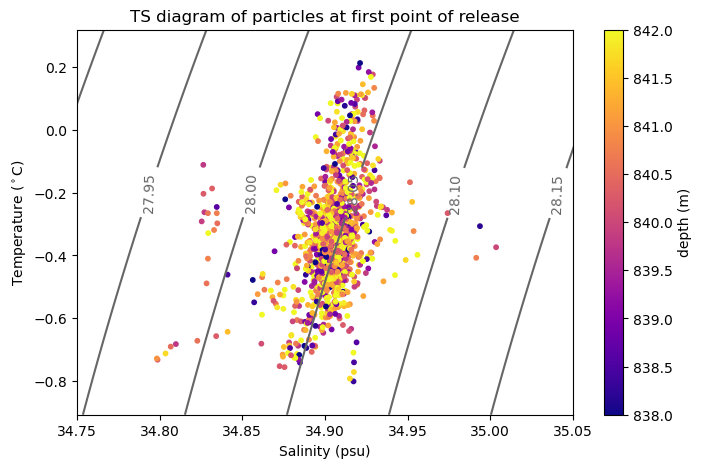

In [198]:
plt.figure(figsize=(8, 5))

# Convert datetime to int64 for color mapping
c_values = z_release_cp#T_release_cp['start_time'].values.astype(np.int64)

# Scatter plot
scatter = plt.scatter(S_release_cp, T_release_cp, 
                      c=c_values, s=10, cmap='plasma',vmin=838,vmax=842)
cbar = plt.colorbar(scatter)
cbar.set_label('depth (m)')

manual_locations = [(34.9, -0.2)]
for level in np.arange(27.7, 28.5, 0.05):
    CS = plt.contour(sigma_contour_release[0], sigma_contour_release[1], sigma_contour_release[2], [level], cmap='Dark2_r') 
    plt.clabel(CS, inline=True, fmt='%1.2f', manual=manual_locations)
plt.xlim(34.75, 35.05)
plt.xlabel('Salinity (psu)')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('TS diagram of particles at first point of release')
plt.show()


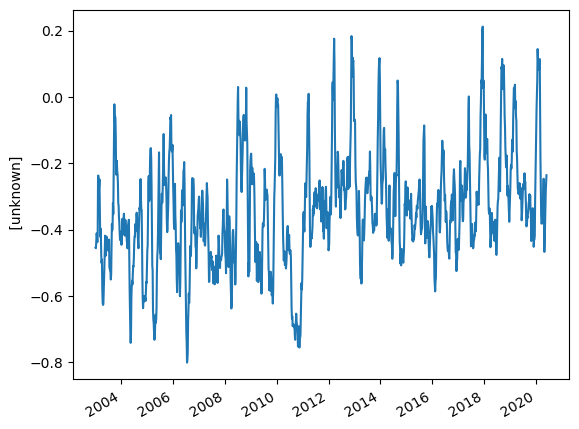

In [54]:
p.groupby('start_time').mean().temp.isel(obs=0, drop=True).plot();

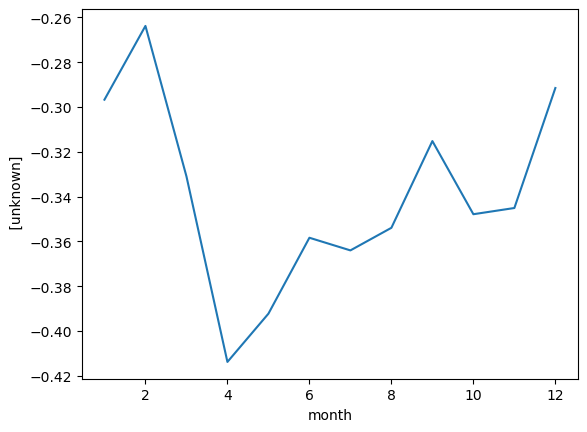

In [26]:
p.groupby('start_time.month').mean().temp.isel(obs=0, drop=True).plot();

In [10]:
# monthly temp means:

monthly_temp_means_release = p.groupby('start_time').mean().temp.isel(obs=0, drop=True).compute()
monthly_salt_means_release = p.groupby('start_time').mean().salt.isel(obs=0, drop=True).compute()

In [11]:
annual_temp_means_release = p.groupby('start_time.year').mean().temp.isel(obs=0, drop=True).compute()
annual_salt_means_release = p.groupby('start_time.year').mean().salt.isel(obs=0, drop=True).compute()

In [119]:
annual_dens_means_release = p.groupby('start_time.year').mean().dens.isel(obs=0, drop=True).compute()


In [31]:
# def get_trend_lin

# # Extract the years and temperature values
# years = annual_temp_means_release.year
# temps = annual_temp_means_release

# # Fit a linear regression model
# coefficients = np.polyfit(years, temps, 1)
# trend = np.poly1d(coefficients)


In [124]:
def detrend_dim(da,dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    coeffs = np.polyfit(da[dim], da, deg)
    return fit, coeffs

In [122]:
# coefficients = np.polyfit(annual_temp_means_release.year,detrend_dim(annual_temp_means_release,dim='year'), 1)
# coefficients

years = annual_dens_means_release.year

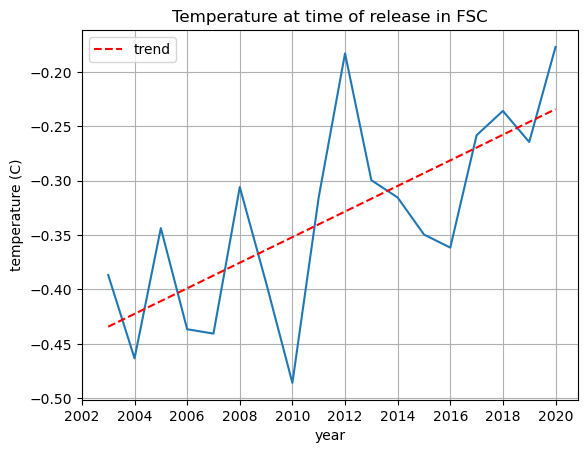

Slope: 0.1176 °C/decade
Intercept: -23.9885 °C


In [38]:


# Plot the original data and the trend line
annual_temp_means_release.plot()
plt.plot(years, detrend_dim(annual_temp_means_release,dim='year')[0], color='red', linestyle='--', label='trend')
plt.ylabel('temperature (C)')
plt.xticks(np.arange(2002, 2020 + 2, 2))
plt.title('Temperature at time of release in FSC')
plt.legend()
plt.grid()
plt.show()

coeffs = detrend_dim(annual_temp_means_release,dim='year')[1]
# Print the slope and intercept of the trend line
slope_per_decade = coeffs[0] * 10
print(f"Slope: {slope_per_decade:.4f} °C/decade")
print(f"Intercept: {coeffs[1]:.4f} °C")

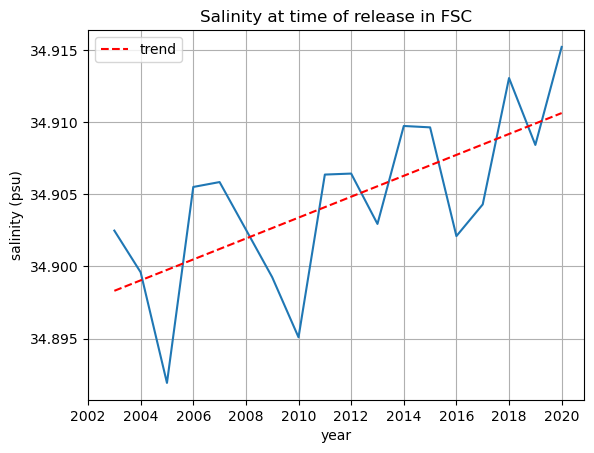

Slope: 0.0072 psu/decade
Intercept: 33.4483 psu


In [39]:
# Plot the original data and the trend line
annual_salt_means_release.plot()
plt.plot(years, detrend_dim(annual_salt_means_release, dim='year')[0], color='red', linestyle='--', label='trend')
plt.ylabel('salinity (psu)')
plt.xticks(np.arange(2002, 2020 + 2, 2))
plt.title('Salinity at time of release in FSC')
plt.legend()
plt.grid()
plt.show()

coeffs = detrend_dim(annual_salt_means_release, dim='year')[1]
# Print the slope and intercept of the trend line
slope_per_decade = coeffs[0] * 10
print(f"Slope: {slope_per_decade:.4f} psu/decade")
print(f"Intercept: {coeffs[1]:.4f} psu")


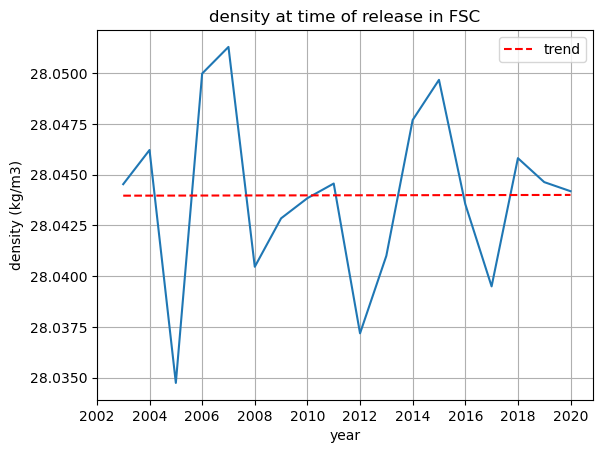

Slope: 0.0000 kg/m3/decade
Intercept: 28.0397 kg/m3


In [125]:


# Plot the original data and the trend line
annual_dens_means_release.plot()
plt.plot(years, detrend_dim(annual_dens_means_release,dim='year')[0], color='red', linestyle='--', label='trend')
plt.ylabel('density (kg/m3)')
plt.xticks(np.arange(2002, 2020 + 2, 2))
plt.title('density at time of release in FSC')
plt.legend()
plt.grid()
plt.show()

coeffs = detrend_dim(annual_dens_means_release,dim='year')[1]
# Print the slope and intercept of the trend line
slope_per_decade = coeffs[0] * 10
print(f"Slope: {slope_per_decade:.4f} kg/m3/decade")
print(f"Intercept: {coeffs[1]:.4f} kg/m3")

In [61]:
# annual_temp_means_release.plot()
# plt.ylabel('temperature (C)')
# plt.xticks(np.arange(2002,2020+2,2))
# plt.title('temperature at time of release in FSC')
# plt.grid()
# plt.show()

# annual_salt_means_release.plot()
# plt.ylabel('salinity (psu)')
# plt.xticks(np.arange(2002,2020+2,2))
# plt.title('salinity at time of release in FSC')
# plt.grid()
# plt.show()

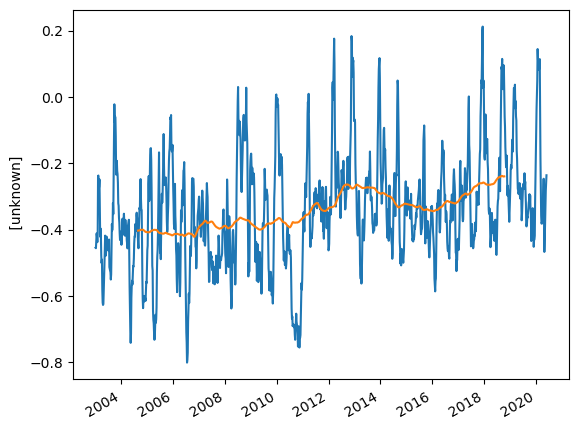

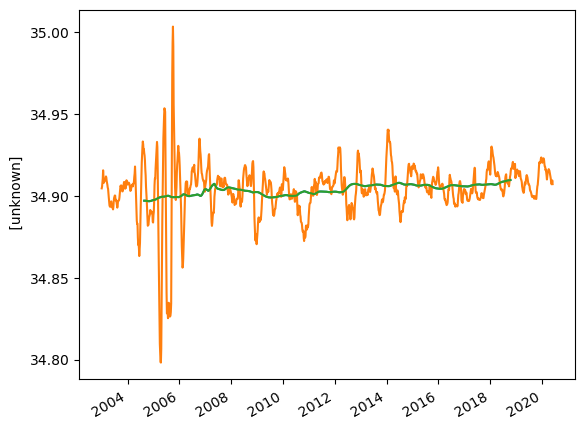

In [72]:
n = 20

monthly_temp_means_release.plot()
#annual_temp_means_release.plot()
monthly_temp_means_release.rolling({'start_time':n*12},center=True).mean().plot()
plt.show()

monthly_salt_means_release.rolling({'start_time':n*12},center=True).mean().plot()
monthly_salt_means_release.plot()
#annual_salt_means_release.plot()
monthly_salt_means_release.rolling({'start_time':n*12},center=True).mean().plot()
plt.show()
plt.show()

In [76]:
ds["time"].isel(trajectory=1).isel(obs=slice(0,10)).values

array(['2003-01-01T00:00:00.000000000', '2002-12-31T12:00:01.000000000',
       '2002-12-31T00:00:00.000000000', '2002-12-30T12:00:01.000000000',
       '2002-12-30T00:00:00.000000000', '2002-12-29T12:00:01.000000000',
       '2002-12-29T00:00:00.000000000', '2002-12-28T12:00:01.000000000',
       '2002-12-28T00:00:00.000000000', '2002-12-27T12:00:01.000000000'],
      dtype='datetime64[ns]')

In [77]:
# from datetime import timedelta, datetime
# '''
# Assign a time to the observations to plot snapshots 
# '''

# # Compute the min and max time values
# time_min = ds_filter["time"].min().compute()
# time_max = ds_filter["time"].max().compute()

# outputdt = timedelta(hours=6*12)

# # timerange in datetime64[ns]
# timerange = np.arange(
#     np.nanmin(ds_filter["time"].values),
#     np.nanmax(ds_filter["time"].values) + np.timedelta64(outputdt),
#     outputdt,
# )

# t = str(timerange[0].astype("timedelta64[h]"))

# time_id = np.where(ds_filter["time"].values == t)



In [199]:
ds

<xarray.Dataset>
Dimensions:     (trajectory: 497743, obs: 20075)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 ... 20069 20070 20071 20072 20073 20074
  * trajectory  (trajectory) int64 1 8 9 14 ... 3518721 3518723 3518726 3518727
Data variables:
    age         (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    lat         (trajectory, obs) float64 dask.array<chunksize=(782, 15330), meta=np.ndarray>
    lon         (trajectory, obs) float64 dask.array<chunksize=(782, 15330), meta=np.ndarray>
    salt        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    temp        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(782, 15330), meta=np.ndarray>
    uvel        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    vvel        (trajectory, obs) float32 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    z           (trajectory, obs) float64 dask.array<chunksize=(782, 15330), meta=np.ndarray>
    sigma0      (trajectory, obs) float64 dask.array<chunksize=(1564, 20075), meta=np.ndarray>
    start_time  (trajectory) datetime64[ns] dask.array<chunksize=(782,), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SampleParticleAdvectionRK4_3Dsamplingagevelocity_...
    parcels_mesh:           spherical
    parcels_version:        3.1.0

## make heatmaps and binning

In [21]:
# p.arange(ds.temp.min().values[()], ds.temp.max().values[()], n) 

In [10]:
def calc_min_max(ds):
    lon_min = float(ds.lon.min().values)
    lon_max = float(ds.lon.max().values)
    lat_min = float(ds.lat.min().values)
    lat_max = float(ds.lat.max().values)
    res = {'lon_min': lon_min, 'lon_max': lon_max,
           'lat_min': lat_min, 'lat_max': lat_max}
    return res


In [11]:

import yaml
import os
outdir = 'data/level3/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
if os.path.exists(f'{outdir}/minmax.yaml'):
    with open(f'{outdir}/minmax.yaml', 'r') as file:
        results = yaml.load(file, Loader=yaml.FullLoader)
else:
    results = calc_min_max(ds)
    with open(f'{outdir}/minmax.yaml', 'w') as file:
        yaml.dump(results, file)

n=0.25
lon_bins = np.arange(results['lon_min'], results['lon_max'], n)
lat_bins = np.arange(results['lat_min'], results['lat_max'], n)

In [37]:

#salt_bins = np.arange(ds.salt.min().values[()], ds.salt.max().values[()], n) 
temp_bins = np.arange(ds.temp.min().values[()], ds.temp.max().values[()], n) 
z_bins = np.arange(ds_filter.z.min().values[()], ds_filter.z.max().values[()], n)
age_bins = np.arange(ds.age.min().values[()], ds.age.max().values[()], n)
#salt_bins = np.arange(ds.salt.min().values[()], ds.salt.max().values[()], n)


In [ ]:
#salt_bins = np.linspace(34.75, 35.5, 51)

#salt_bins = np.arange(ds.salt.min().values[()], ds.salt.max().values[()], n) 

In [38]:
salt_bins = np.linspace(34.75, 35.5, 81)
dens_bins = np.linspace(26,30,81)

In [242]:
#dens_bins = np.arange(ds.sigma0.min().values[()], ds.sigma0.max().values[()], n)

In [216]:
# n = 51 # adjust bin size, 71? originally 51 

# lon_bins = np.linspace(ds.lon.min().values[()], ds.lon.max().values[()], n) # consider changing the bins to dask arrays, and chunking obs counts maybe
# lat_bins = np.linspace(ds.lat.min().values[()], ds.lat.max().values[()], n) # providing lon,,lat bins are chunked dask arrays 
# #salt_bins = np.linspace(ds.salt.min().values[()], ds.salt.max().values[()], n) 
# temp_bins = np.linspace(ds.temp.min().values[()], ds.temp.max().values[()], n) 
# z_bins = np.linspace(ds_filter.z.min().values[()], ds_filter.z.max().values[()], n)
# age_bins = np.linspace(ds.age.min().values[()], ds.age.max().values[()], n)


In [12]:
def rechunk_for_hist(var):
    return var.chunk({'trajectory': 50, 'time': -1})

lon_rechunk = rechunk_for_hist(ds['lon'])
lat_rechunk = rechunk_for_hist(ds['lat'])

In [41]:


temp_rechunk = rechunk_for_hist(ds['temp'])
salt_rechunk = rechunk_for_hist(ds['salt'])
depth_rechunk = rechunk_for_hist(ds['z'])
age_rechunk = rechunk_for_hist(ds['age'])
dens_rechunk = rechunk_for_hist(ds['sigma0'])

In [62]:

#rechunk_test_temp = ds_filter['temp'].chunk({'trajectory': 50, 'obs': -1})
#rechunk_test_temp

#salt_rechunk

# test_distrib = xhist(
#     rechunk_test_temp, bins=[temp_bins], dim=["obs", "trajectory"]
# )

# temp_perc_distrib_compute = percentage_distribution(test_distrib, dim='temp_bin').compute()

In [63]:
# time_bins_1y = np.arange(
#     np.datetime64('1993-01-01'),
#     np.datetime64('2020-05-01'), np.timedelta64(1, 'Y'),
#     dtype='datetime64[Y]').astype('datetime64[D]').astype('datetime64[ns]')
# time_bins_1y.shape

In [42]:
heat_map_z = xhist(ds_filter.z, bins=[z_bins], dim=['trajectory'],
    bin_dim_suffix="") 

heat_map_salt = xhist(ds.salt, bins=[salt_bins], dim=['trajectory'],
    bin_dim_suffix="") 

heat_map_dens = xhist(ds.sigma0, bins=[dens_bins], dim=['trajectory'],
    bin_dim_suffix="") 

heat_map_temp = xhist(ds.temp, bins=[temp_bins], dim=['trajectory'],
    bin_dim_suffix="") 

depth_distribution = xhist(
    depth_rechunk, bins=[z_bins], dim=["time", "trajectory"]
)

age_distribution = xhist(
    age_rechunk, bins=[age_bins], dim=["time", "trajectory"]
)

temp_distribution = xhist(
    temp_rechunk, bins=[temp_bins], dim=["time", "trajectory"]
)

salt_distribution = xhist(
    salt_rechunk, bins=[salt_bins], dim=["time", "trajectory"]
)

dens_distribution = xhist(
    dens_rechunk, bins=[dens_bins], dim=["time", "trajectory"]
)


In [17]:
# temp_map = temp_distribution_map_cp.T #.where(temp_distribution_map_cp.T =! 0) #.plot()#.plot(vmin=-10,vmax=10);

# nans = temp_map.where(temp_map!=0)

In [43]:
# datetime_array = [datetime.fromtimestamp(ns / 1e9) for ns in ds_filter.time.isel(trajectory=100).values[0:None]]
# formatted_dates = [dt.strftime('%Y-%m-%d') for dt in datetime_array]

# formatted_dates
def percentage_distribution(distrib, dim=None):
    total_counts = distrib.sum(dim=None)  # Sum over the temperature dimension , 'temp_bin'

    # Step 2: Calculate percentages
    percentage_distribution = (distrib / total_counts) * 100
    return percentage_distribution

In [44]:


temp_perc_distrib_compute = percentage_distribution(temp_distribution, dim='temp_bin').compute()

depth_perc_distrib_compute = percentage_distribution(depth_distribution, dim='z_bin').compute()

In [45]:
age_perc_distrib_compute = percentage_distribution(age_distribution, dim='age_bin').compute()

In [46]:

salt_perc_distrib_compute = percentage_distribution(salt_distribution, dim='salt_bin').compute()


In [47]:
dens_perc_distrib_compute = percentage_distribution(dens_distribution, dim='dens_bin').compute()


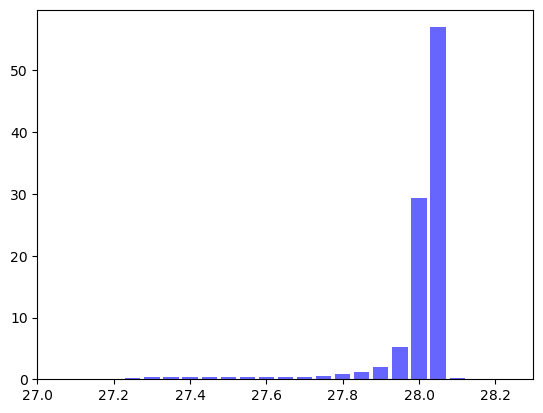

In [48]:
# salt_distribution_bintest_compute = percentage_distribution(salt_distribution_bintest, dim='salt_bin').compute()

plt.bar(dens_bins[:-1], dens_perc_distrib_compute, 
         width=0.8* (dens_bins[1] - dens_bins[0]), color='b', alpha=0.6, label='Counts (%)')
plt.xlim(27,28.3)
plt.show()

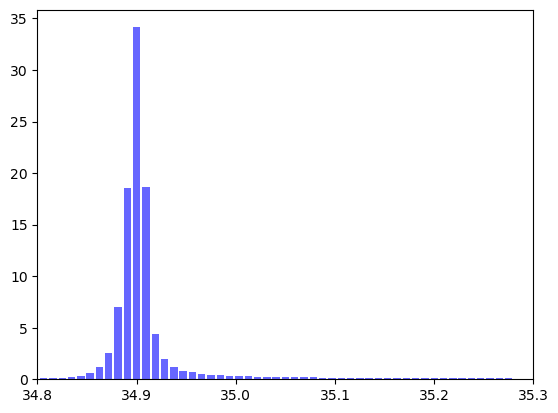

In [49]:
# salt_distribution_bintest_compute = percentage_distribution(salt_distribution_bintest, dim='salt_bin').compute()

plt.bar(salt_bins[:-1], salt_perc_distrib_compute, 
         width=0.8* (salt_bins[1] - salt_bins[0]), color='b', alpha=0.6, label='Counts (%)')
plt.xlim(34.8,35.3)
plt.show()

In [ ]:
# plt.bar(salt_bins[:-1], salt_perc_distrib_compute, 
#          width=0.8 * (salt_bins[1] - salt_bins[0]), color='b', alpha=0.6, label='Counts (%)')
# plt.show()

# plt.bar(salt_bin_test[:-1], salt_distribution_bintest_compute, 
#          width=0.8 * (salt_bin_test[1] - salt_bin_test[0]), color='b', alpha=0.6, label='Counts (%)')
# plt.xlim(34.7,35.4)
# plt.show()

In [50]:
heat_map_dens = heat_map_dens.T.compute()

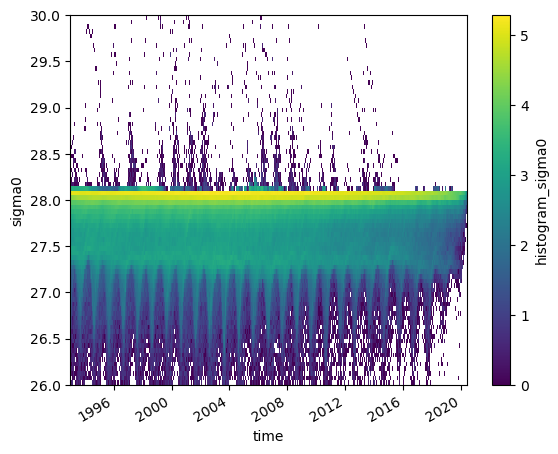

In [51]:
np.log10(heat_map_dens).plot();

In [52]:
heat_map_salt = heat_map_salt.T.compute()

In [55]:
# heat_map_z = heat_map_z.T.compute()

# heat_map_temp = heat_map_temp.T.compute()

In [56]:
plt.rcParams.update({'font.size':10})

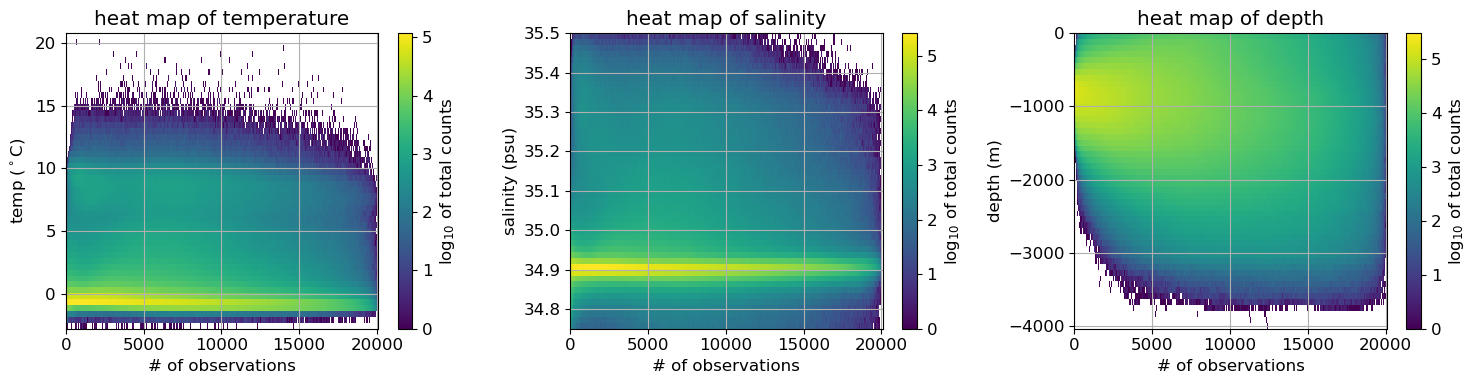

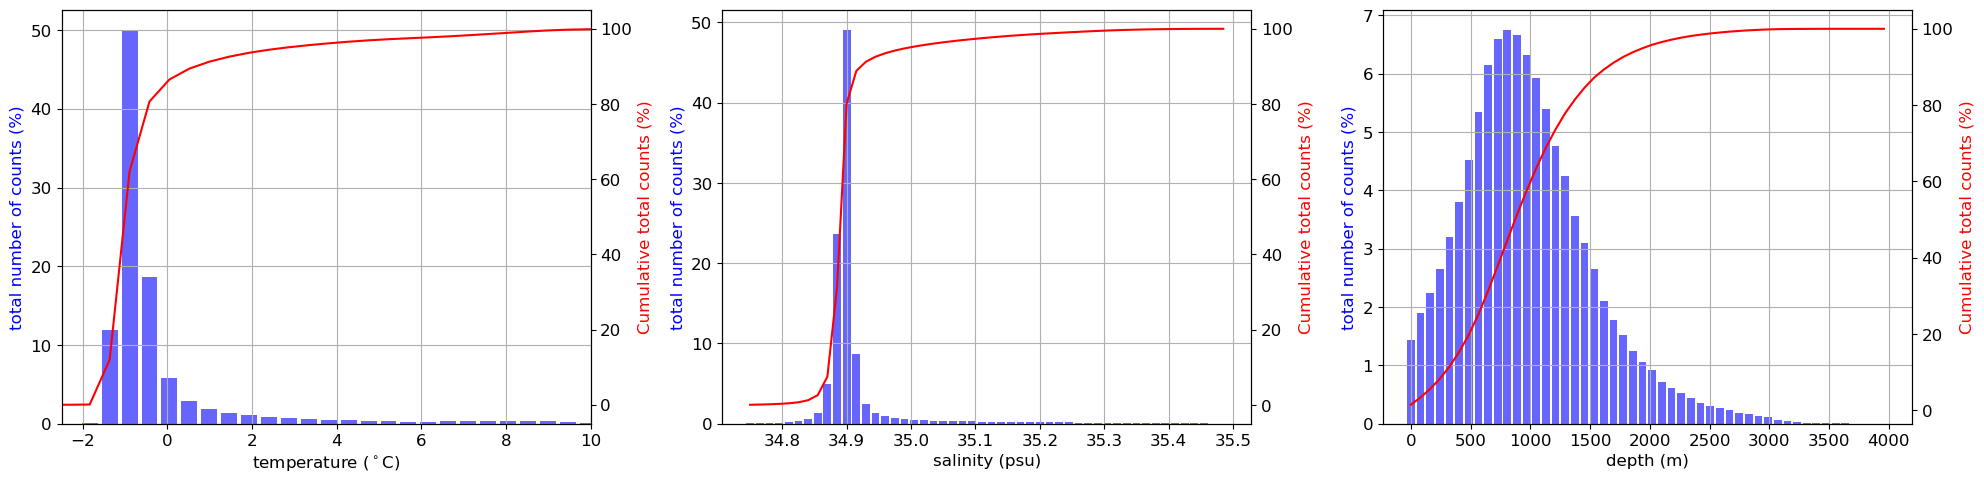

In [147]:
# temp_distribution_orig = xhist(
#     ds.temp, bins=[temp_bins], dim=["obs", "trajectory"]
# )

# temp_distribution_orig

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# First plot
c1 = axs[2].pcolormesh(heat_map_z.obs, -heat_map_z.z, np.log10(heat_map_z), shading='auto')
cb1 = plt.colorbar(c1, ax=axs[0])
cb1.set_label(r'log$_{10}$ of total counts')
axs[2].set_xlabel('# of observations')
axs[2].set_ylabel('depth (m)')
axs[2].set_title('heat map of depth')
axs[2].grid()

# Second plot
c2 = axs[1].pcolormesh(heat_map_salt.obs, heat_map_salt.salt, np.log10(heat_map_salt), shading='auto')
cb2 = plt.colorbar(c2, ax=axs[1])
cb2.set_label(r'log$_{10}$ of total counts')
axs[1].set_xlabel('# of observations')
axs[1].set_ylabel('salinity (psu)')
axs[1].set_title('heat map of salinity')
#axs[1].set_ylim(28,37)
axs[1].grid()

# Third plot
c3 = axs[0].pcolormesh(heat_map_temp.obs, heat_map_temp.temp, np.log10(heat_map_temp), shading='auto')
cb3 = plt.colorbar(c3, ax=axs[2])
cb3.set_label(r'log$_{10}$ of total counts')
axs[0].set_xlabel('# of observations')
axs[0].set_ylabel(r'temp ($^\circ$C)')
axs[0].set_title('heat map of temperature')
axs[0].grid()
# Adjust layout
plt.tight_layout()
plt.show()

# Create a figure with 1 row and 3 columns
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Plot for temperature distribution
ax1.bar(temp_bins[:-1], temp_perc_distrib_compute, 
         width=0.8 * (temp_bins[1] - temp_bins[0]), color='b', alpha=0.6, label='Counts (%)')

# Create a twin axis for the cumulative distribution
ax1_twin = ax1.twinx()
cumulative_distribution_temp = temp_perc_distrib_compute.cumsum()
ax1_twin.plot(temp_bins[:-1], cumulative_distribution_temp, color='r', label='Cumulative Counts (%)')

# Set limits and labels
ax1.set_xlim(-2.5, 10)
ax1.set_xlabel(r'temperature ($^\circ$C)')
ax1.set_ylabel('total number of counts (%)', color='b')
ax1_twin.set_ylabel('Cumulative total counts (%)', color='r')
ax1.grid()

# Plot for salinity distribution
ax2.bar(salt_bins[:-1], salt_perc_distrib_compute, 
         width=0.8 * (salt_bins[1] - salt_bins[0]), color='b', alpha=0.6, label='Counts (%)')

# Create a twin axis for the cumulative distribution
ax2_twin = ax2.twinx()
cumulative_distribution_salt = salt_perc_distrib_compute.cumsum()
ax2_twin.plot(salt_bins[:-1], cumulative_distribution_salt, color='r', label='Cumulative Counts (%)')

# Set limits and labels
#ax2.set_xlim(33., 38)
ax2.set_xlabel(r'salinity (psu)')
ax2.set_ylabel('total number of counts (%)', color='b')
ax2_twin.set_ylabel('Cumulative total counts (%)', color='r')
ax2.grid()

# Plot for depth distribution
ax3.bar(z_bins[:-1], depth_perc_distrib_compute, 
         width=0.8 * (z_bins[1] - z_bins[0]), color='b', alpha=0.6, label='Counts (%)')

# Create a twin axis for the cumulative distribution
ax3_twin = ax3.twinx()
cumulative_distribution_depth = depth_perc_distrib_compute.cumsum()
ax3_twin.plot(z_bins[:-1], cumulative_distribution_depth, color='r', label='Cumulative Counts (%)')

# Set limits and labels
ax3.set_xlabel(r'depth (m)')
ax3.set_ylabel('total number of counts (%)', color='b')
ax3_twin.set_ylabel('Cumulative total counts (%)', color='r')
ax3.grid()

# Adjust layout
plt.tight_layout()
plt.show()


In [13]:
# converting the age from nano seconds 

hours_to_days=0.0416667
hours_to_months=0.00136986
hours_to_years=0.000114155
time_conversion = hours_to_days

KeyboardInterrupt: 

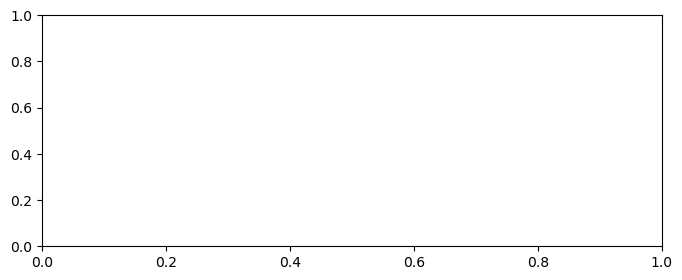

In [58]:
fig, ax = plt.subplots(figsize=(8, 3))

# Plot the bar chart for age distribution
ax.bar(age_bins[:-1] * time_conversion, age_perc_distrib_compute, 
    width=0.8 * (age_bins[1] * time_conversion - age_bins[0] * time_conversion), 
    color='b', alpha=0.6, label='Counts (%)')

# Create a twin axis for the cumulative distribution
ax_twin = ax.twinx()
cumulative_distribution_age = age_perc_distrib_compute.cumsum()
ax_twin.plot(age_bins[:-1] * time_conversion, cumulative_distribution_age, 
          color='r', label='Cumulative Counts (%)')

# Set labels and titles
ax.set_xlabel('Age of particles (days)')
ax.set_ylabel('Number of counts (%)', color='b')
ax_twin.set_ylabel('Cumulative counts (%)', color='r')

# Add grid and legend
ax.grid()
#fig.legend(loc='upper right')
plt.title('age of particles distirbution')
plt.show()


In [59]:
client.close()

In [101]:
# #temp_perc_distrib_compute = percentage_distribution(temp_distribution, dim='temp_bin').compute()

# total_salt_counts = salt_distribution.sum(dim=None)
# if total_salt_counts != 0:
# 	salt_perc_distrib_compute = (salt_distribution / total_salt_counts * 100).compute()
# else:
# 	salt_perc_distrib_compute = salt_distribution * 0

# # total_depth_counts = depth_distribution.sum(dim=None)
# # if total_depth_counts != 0:
# # 	depth_perc_distrib_compute = (depth_distribution / total_depth_counts * 100).compute()
# # else:
# # 	depth_perc_distrib_compute = depth_distribution * 0

## get maps

In [14]:
land_mask = mesh_mask.tmask.where(mesh_mask.tmask!=0).isel(t=0,z=0)

In [19]:
heat_map_obs = xhist(ds_filter.lat, ds_filter.lon, bins=[lat_bins, lon_bins], dim=['time'],
    bin_dim_suffix="") #dim=['obs'],

heat_map_traj = xhist(ds_filter.lat, ds_filter.lon, bins=[lat_bins, lon_bins], #, dim=['trajectory'], # with dim=trajectory, the  chunks were way too big over 5 Gib
    bin_dim_suffix="")

   

In [22]:
#client.restart()

#cluster.scale(15) #

In [20]:
# Summing particle counts over the whole integration period
heat_map_obs_sum = heat_map_traj#.sum(dim='obs')

# Dividing by the total number of particle counts for all bins
total_counts = heat_map_obs_sum.sum()
heat_map_normalized = heat_map_obs_sum / total_counts

In [23]:
# Calculate the total number of observations
total_observations = ds_filter.time.size

# Calculate the probability for each bin
heat_map_probability_obs = (heat_map_obs / total_observations) * 100


In [22]:
#heat_map_probability_obs_cp = heat_map_probability_obs.compute()

In [24]:
# Summing particle counts over the whole integration period, considering each particle only once per bin
heat_map_obs_unique = (heat_map_obs > 0).sum(dim='trajectory')

# Dividing by the total number of particles to get the probability for each bin
total_particles = ds_filter.trajectory.size
heat_map_probability = (heat_map_obs_unique / total_particles) * 100

In [25]:
#rechunked = heat_map_normalized.chunk({'lat': 100, 'lon': 100})

# Compute the result
heat_map_normalized_comp = heat_map_normalized.compute()

In [26]:
heat_map_compute = heat_map_obs.sum(dim='trajectory').compute()

In [27]:
heat_map_probability_compute = heat_map_probability.compute()

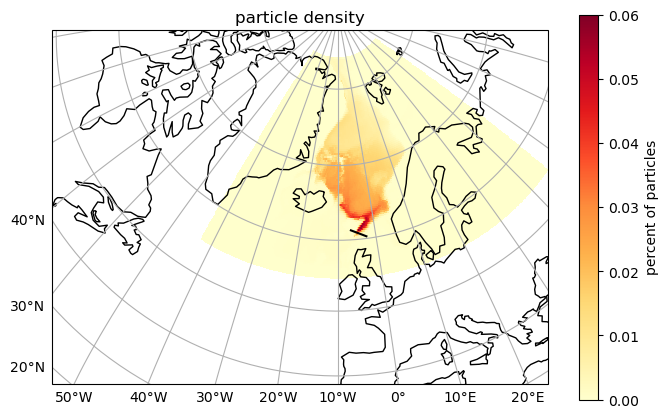

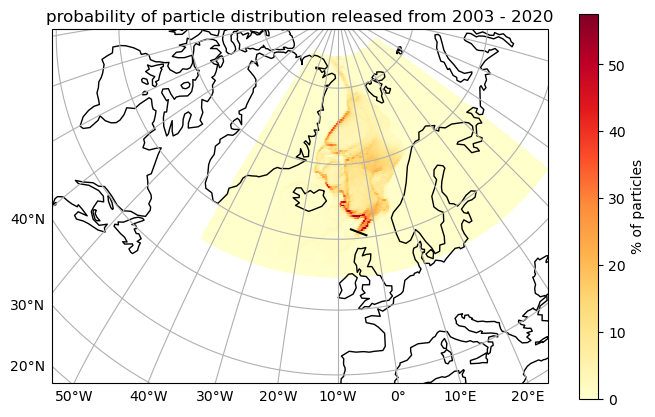

In [29]:


fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
# Plot the bathymetry data on the orthographic map
pcolormesh = ax.pcolormesh(
    mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
# Add color bar for bathymetry
#plt.colorbar(pcolormesh, ax=ax, orientation="vertical", label="bathymetry (m)")

x = ax.pcolormesh(heat_map_normalized_comp.lon,heat_map_normalized_comp.lat,heat_map_normalized_comp*100,cmap='YlOrRd',transform=ccrs.PlateCarree())
cbar=plt.colorbar(x)
cbar.set_label('percent of particles')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
plt.title('particle density')
plt.show()


fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
# Plot the bathymetry data on the orthographic map
pcolormesh = ax.pcolormesh(
    mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
# Add color bar for bathymetry
#plt.colorbar(pcolormesh, ax=ax, orientation="vertical", label="bathymetry (m)")

x = ax.pcolormesh(heat_map_probability_compute.lon,heat_map_probability_compute.lat,heat_map_probability_compute,cmap='YlOrRd',transform=ccrs.PlateCarree())
cbar=plt.colorbar(x)
cbar.set_label(r'% of particles')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
plt.title('probability of particle distribution released from 2003 - 2020')
plt.show()

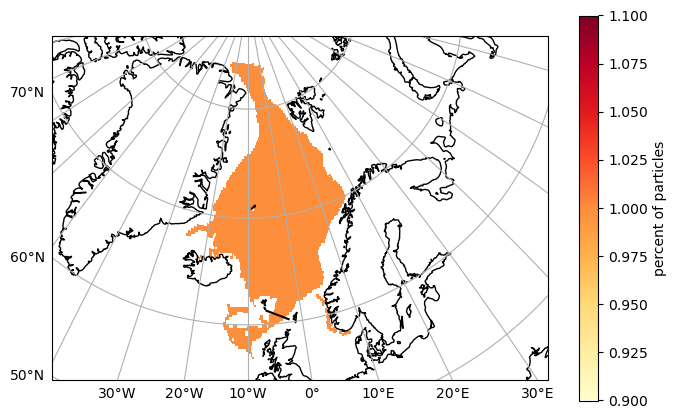

In [42]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
# Plot the bathymetry data on the orthographic map
pcolormesh = ax.pcolormesh(
    mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
x = ax.pcolormesh(heat_map_normalized_comp.lon,heat_map_normalized_comp.lat,xr.where(100*heat_map_normalized_comp>0.001,1, np.nan),cmap='YlOrRd',transform=ccrs.PlateCarree())
cbar=plt.colorbar(x)
cbar.set_label('percent of particles')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
plt.show()



In [47]:
# fig = plt.figure(figsize=(8, 5))
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
# # Plot the bathymetry data on the orthographic map
# pcolormesh = ax.pcolormesh(
#     mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
#     transform=ccrs.PlateCarree(), cmap='binary')
# x = ax.pcolormesh(heat_map_normalized_comp.lon,heat_map_normalized_comp.lat,xr.where(heat_map_probability_compute>3,1, np.nan),cmap='YlOrRd',transform=ccrs.PlateCarree())
# cbar=plt.colorbar(x)
# cbar.set_label('percent of particles')
# ax.coastlines()
# gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
# gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
# gl.xlabel_style = {'size': 10}
# gl.ylabel_style = {'size': 10}

# ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
# plt.show()

In [28]:
#heat_map_probability_compute

mask_0_probability = xr.where(100*heat_map_normalized_comp>0.001,1, np.nan)

In [29]:
mask_0_probability = mask_0_probability.rename({'lat':'lat_bin','lon':'lon_bin'})

In [24]:
# heat_map_probability_obs_cp.sum(dim='trajectory').plot();

# get maps of mean temp, salinity, and age 

In [32]:
# def get_mean_maps(ds):
#     weights = xr.ones_like(ds)
#     weighted_sum = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=ds, dim=["obs", "trajectory"])
#     counts = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=weights, dim=["obs", "trajectory"])
#     mean_temp = weighted_sum / counts
#     return mean_temp

def get_mean_maps(ds,lon_rechunk,lat_rechunk):
    weights = xr.ones_like(ds)
    weighted_sum = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=ds, dim=["time", "trajectory"])
    counts = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=weights, dim=["time", "trajectory"])
    mean_temp = weighted_sum / counts
    return mean_temp

In [85]:
# def get_mean_maps(ds):
#     weights = xr.ones_like(ds)
#     weighted_sum = xhist(ds['lon'], ds['lat'], bins=[lon_bins, lat_bins], weights=ds, dim=["obs", "trajectory"])
#     counts = xhist(ds['lon'], ds['lat'], bins=[lon_bins, lat_bins], weights=weights, dim=["obs", "trajectory"])
#     mean_temp = weighted_sum / counts
#     return mean_temp



In [33]:
mean_salt = get_mean_maps(ds.salt,lon_rechunk,lat_rechunk)
mean_age = get_mean_maps(ds.age,lon_rechunk,lat_rechunk)
mean_temp = get_mean_maps(ds.temp,lon_rechunk,lat_rechunk)

In [39]:
mean_vvel = get_mean_maps(ds.vvel,lon_rechunk,lat_rechunk)
mean_vvel_cp = mean_vvel.compute()

In [87]:
mean_uvel = get_mean_maps(ds.uvel,lon_rechunk,lat_rechunk)
mean_uvel_cp = mean_uvel.compute()

In [40]:
mean_depth = get_mean_maps(ds.z)
mean_depth_cp = mean_depth.compute()

In [34]:
%%time 

mean_age_cp = mean_age.compute()

CPU times: user 10min 49s, sys: 3min 37s, total: 14min 26s
Wall time: 1min 51s


In [269]:
mean_dens = get_mean_maps(ds.sigma0)
mean_dens_cp = mean_dens.compute()

In [271]:
#mean_dens_cp.to_netcdf('data/level3/mean_dens_cp.nc')

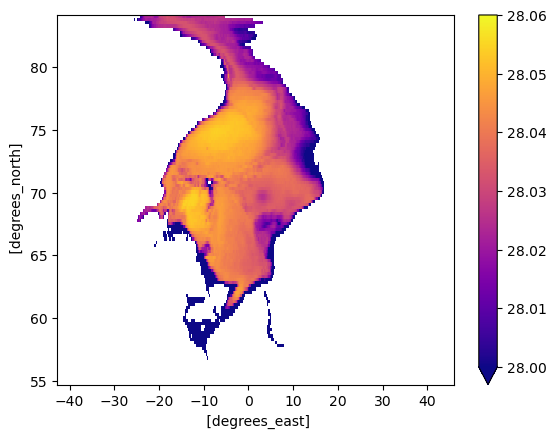

In [286]:
(mean_dens_cp.T*mask_0_probability).plot(vmin=28,vmax=28.06,cmap='plasma');

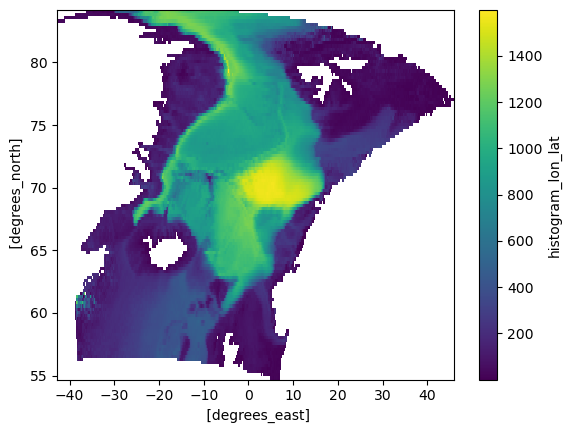

In [42]:
mean_depth_cp.T.plot();

In [ ]:
#(mean_age_cp.T*hours_to_years).plot();
#plt.pcolormesh(mask_0_probability*mean_age_cp.T)

In [116]:
mean_speed_cp = (mean_uvel_cp**2 + mean_vvel_cp**2)**.5

In [35]:
mean_salt_cp = mean_salt.compute()
mean_temp_cp = mean_temp.compute()

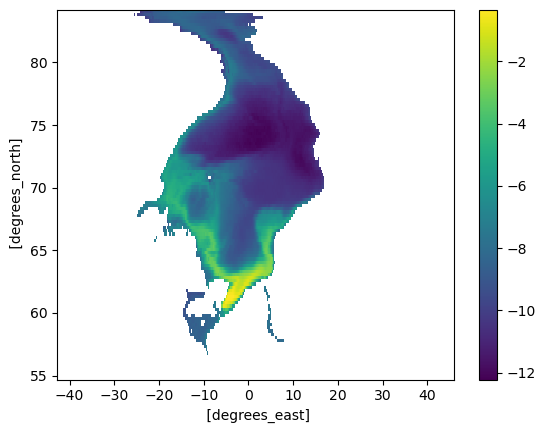

In [36]:
(mean_age_cp.T*hours_to_years*mask_0_probability).plot();

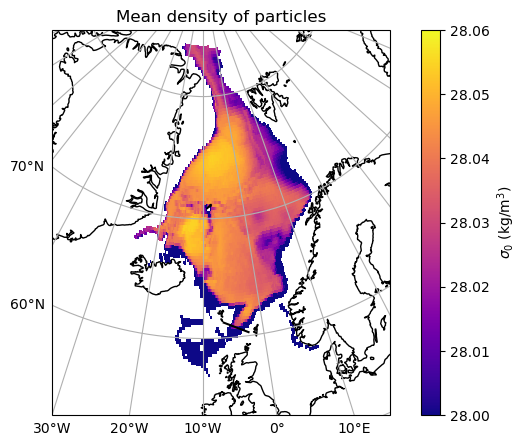

In [ ]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
#ax.set_extent([-40, 15, 51, 85], crs=ccrs.PlateCarree())
ax.set_extent([-30, 15, 51, 85], crs=ccrs.PlateCarree())
# Plot the bathymetry data on the orthographic map
pcolormesh = ax.pcolormesh(
    mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
# Add color bar for bathymetry
#plt.colorbar(pcolormesh, ax=ax, orientation="vertical", label="bathymetry (m)")

x = ax.pcolormesh(heat_map_probability_compute.lon,heat_map_probability_compute.lat,mean_dens_cp.T*mask_0_probability,vmin=28,vmax=28.06,cmap='plasma',transform=ccrs.PlateCarree())
cbar=plt.colorbar(x)
cbar.set_label(r'$\sigma_0$ (kg/m$^3$)')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
plt.title('Mean density of particles')
plt.show()

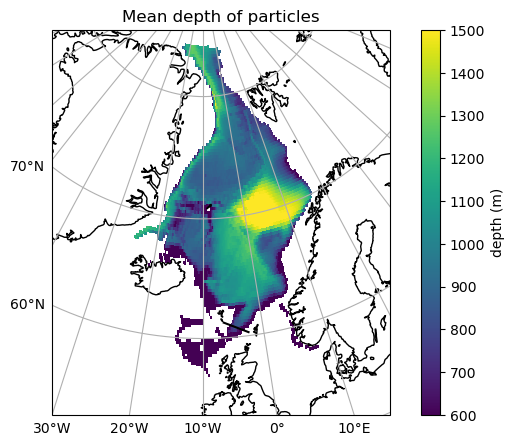

In [60]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
#ax.set_extent([-40, 15, 51, 85], crs=ccrs.PlateCarree())
ax.set_extent([-30, 15, 51, 85], crs=ccrs.PlateCarree())
# Plot the bathymetry data on the orthographic map
pcolormesh = ax.pcolormesh(
    mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
# Add color bar for bathymetry
#plt.colorbar(pcolormesh, ax=ax, orientation="vertical", label="bathymetry (m)")

x = ax.pcolormesh(heat_map_probability_compute.lon,heat_map_probability_compute.lat,mean_depth_cp.T*mask_0_probability,
                  vmin=600,vmax=1500,cmap='viridis',transform=ccrs.PlateCarree())
cbar=plt.colorbar(x)
cbar.set_label(r'depth (m)')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
plt.title('Mean depth of particles')
plt.show()

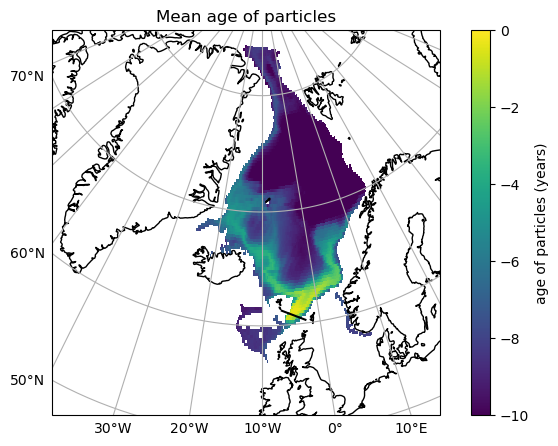

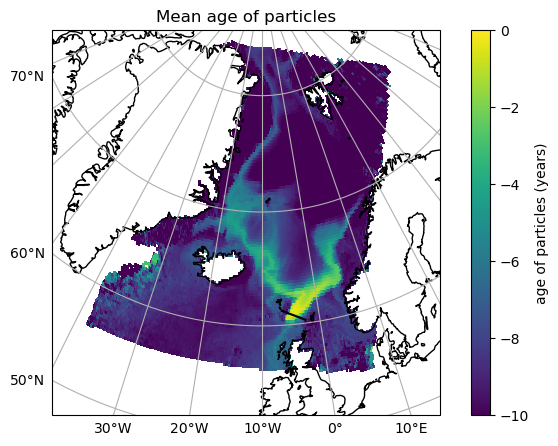

In [105]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
ax.set_extent([-40, 15, 51, 85], crs=ccrs.PlateCarree())
# Plot the bathymetry data on the orthographic map
pcolormesh = ax.pcolormesh(
    mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
# Add color bar for bathymetry
#plt.colorbar(pcolormesh, ax=ax, orientation="vertical", label="bathymetry (m)")

x = ax.pcolormesh(heat_map_probability_compute.lon,heat_map_probability_compute.lat,mean_age_cp.T*hours_to_years*mask_0_probability,vmin=-10,vmax=0,cmap='viridis',transform=ccrs.PlateCarree())
cbar=plt.colorbar(x)
cbar.set_label(r'age of particles (years)')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
plt.title('Mean age of particles')
plt.show()


fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
ax.set_extent([-40, 15, 51, 85], crs=ccrs.PlateCarree())
# Plot the bathymetry data on the orthographic map
pcolormesh = ax.pcolormesh(
    mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
# Add color bar for bathymetry
#plt.colorbar(pcolormesh, ax=ax, orientation="vertical", label="bathymetry (m)")

x = ax.pcolormesh(heat_map_probability_compute.lon,heat_map_probability_compute.lat,mean_age_cp.T*hours_to_years,vmin=-10,vmax=0,cmap='viridis',transform=ccrs.PlateCarree())
cbar=plt.colorbar(x)
cbar.set_label(r'age of particles (years)')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
plt.title('Mean age of particles')
plt.show()



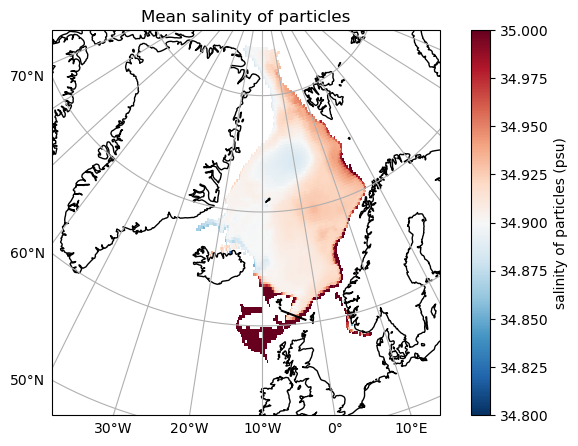

In [95]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
ax.set_extent([-40, 15, 51, 85], crs=ccrs.PlateCarree())
# Plot the bathymetry data on the orthographic map
pcolormesh = ax.pcolormesh(
    mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
x = ax.pcolormesh(heat_map_probability_compute.lon,heat_map_probability_compute.lat, mean_salt_cp.T*mask_0_probability,vmin=34.8,vmax=35,cmap='RdBu_r',transform=ccrs.PlateCarree())
cbar=plt.colorbar(x)
cbar.set_label(r'salinity of particles (psu)')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
plt.title('Mean salinity of particles')
plt.show()



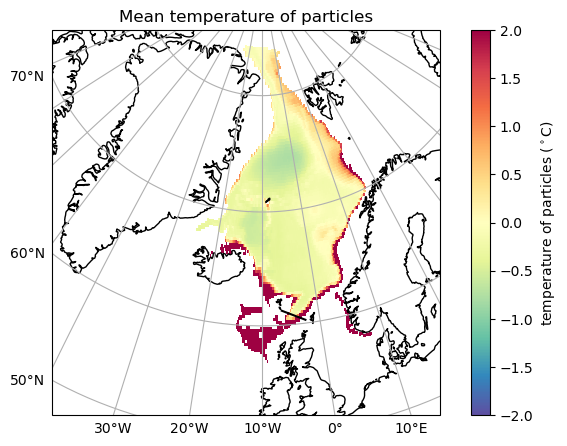

In [114]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
ax.set_extent([-40, 15, 51, 85], crs=ccrs.PlateCarree())
# Plot the bathymetry data on the orthographic map
pcolormesh = ax.pcolormesh(
    mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
x = ax.pcolormesh(heat_map_probability_compute.lon,heat_map_probability_compute.lat,mean_temp_cp.T*mask_0_probability,vmin=-2,vmax=2,
                  cmap='Spectral_r',transform=ccrs.PlateCarree())
cbar=plt.colorbar(x)
cbar.set_label(r'temperature of particles ($^\circ$C)')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
plt.title('Mean temperature of particles')
plt.show()



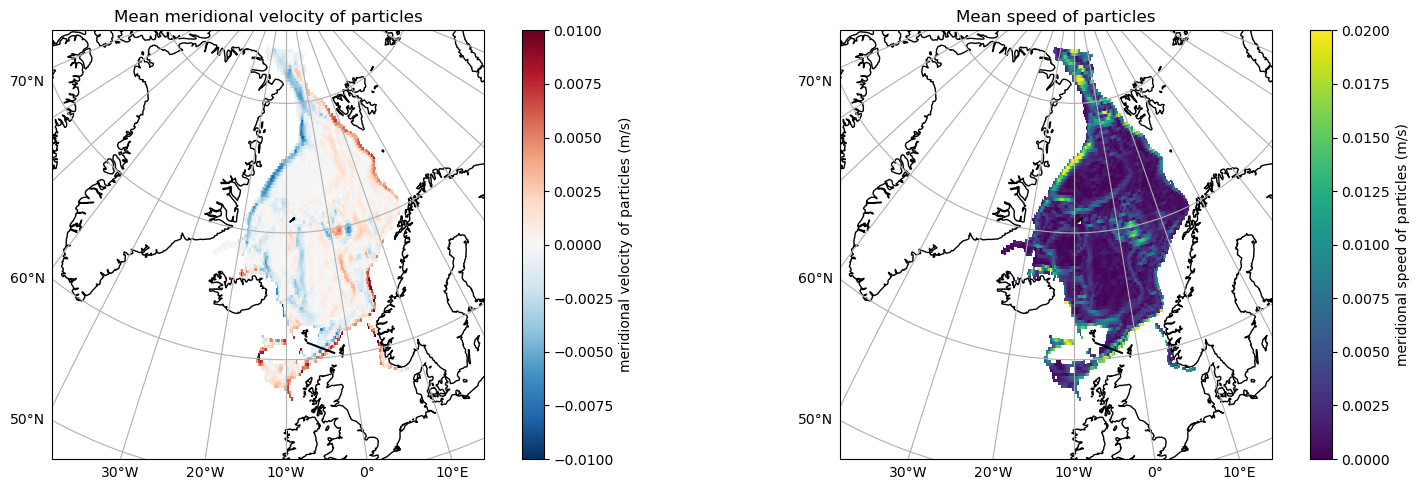

In [157]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), subplot_kw={'projection': ccrs.Orthographic(central_longitude=-10, central_latitude=77)})

# First plot
axs[0].set_extent([-40, 15, 51, 85], crs=ccrs.PlateCarree())
pcolormesh = axs[0].pcolormesh(
    mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
x1 = axs[0].pcolormesh(mean_vvel_cp.lon_bin, mean_vvel_cp.lat_bin, mean_vvel_cp.T * 1e4 * mask_0_probability, cmap='RdBu_r', vmin=-.01, vmax=.01, transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(x1, ax=axs[0])
cbar1.set_label(r'meridional velocity of particles (m/s)')
axs[0].coastlines()
gl1 = axs[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl1.xlabels_top = False
gl1.ylabels_right = False
gl1.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl1.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl1.xlabel_style = {'size': 10}
gl1.ylabel_style = {'size': 10}
axs[0].plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
axs[0].set_title('Mean meridional velocity of particles')

# Second plot
axs[1].set_extent([-40, 15, 51, 85], crs=ccrs.PlateCarree())
pcolormesh = axs[1].pcolormesh(
    mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
x2 = axs[1].pcolormesh(mean_vvel_cp.lon_bin, mean_vvel_cp.lat_bin, mean_speed_cp.T * 1e4 * mask_0_probability, cmap='viridis', vmin=0, vmax=.02, transform=ccrs.PlateCarree())
cbar2 = plt.colorbar(x2, ax=axs[1])
cbar2.set_label(r'meridional speed of particles (m/s)')
axs[1].coastlines()
gl2 = axs[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl2.xlabels_top = False
gl2.ylabels_right = False
gl2.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl2.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl2.xlabel_style = {'size': 10}
gl2.ylabel_style = {'size': 10}
axs[1].plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
axs[1].set_title('Mean speed of particles')

plt.tight_layout()
plt.show()


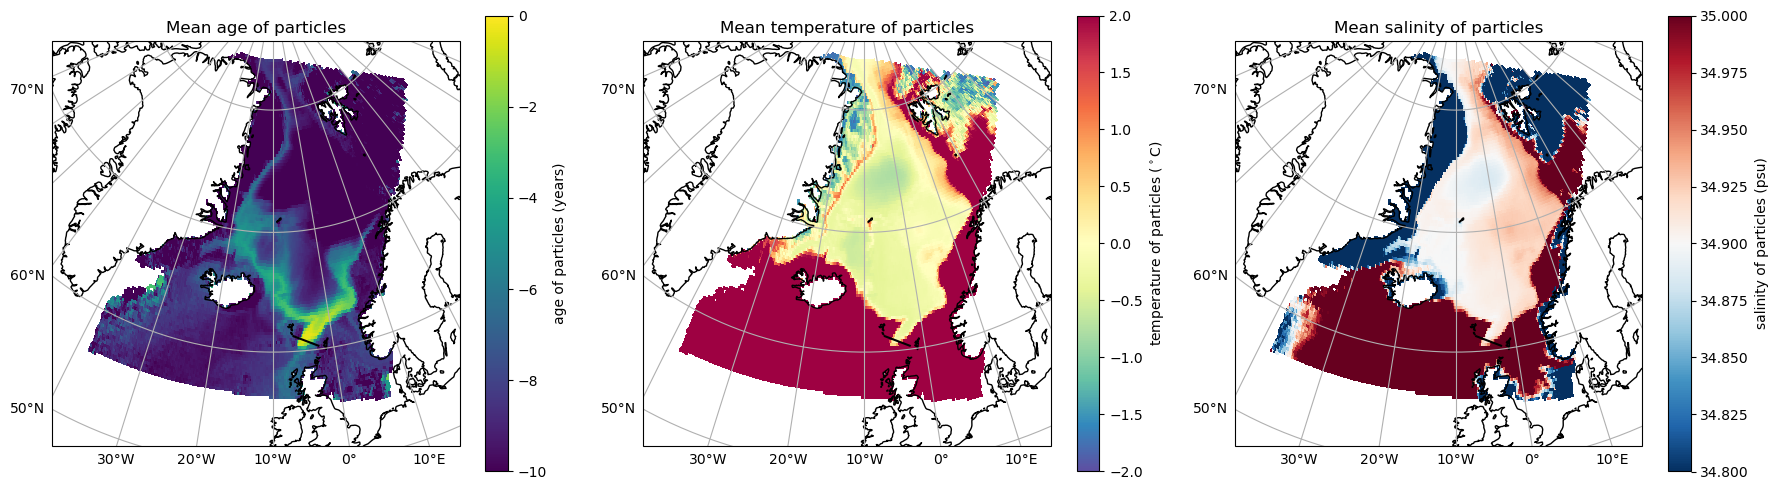

In [103]:

# Create a figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 5), subplot_kw={'projection': ccrs.Orthographic(central_longitude=-10, central_latitude=77)})

# Set the extent for all subplots
for ax in axs:
    ax.set_extent([-40, 15, 51, 85], crs=ccrs.PlateCarree())
    # Plot the bathymetry data on the orthographic map
    pcolormesh = ax.pcolormesh(
        mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, 
        transform=ccrs.PlateCarree(), cmap='binary')

    # Add coastlines
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
    gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

# Plot the first subplot (Mean age of particles)
x1 = axs[0].pcolormesh(heat_map_probability_compute.lon, heat_map_probability_compute.lat, mean_age_cp.T * hours_to_years, vmin=-10, vmax=0, cmap='viridis', transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(x1, ax=axs[0], orientation="vertical")
cbar1.set_label(r'age of particles (years)')
axs[0].plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
axs[0].set_title('Mean age of particles')

# Plot the second subplot (Mean temperature of particles)
x2 = axs[1].pcolormesh(heat_map_probability_compute.lon, heat_map_probability_compute.lat, mean_temp_cp.T, vmin=-2, vmax=2, cmap='Spectral_r', transform=ccrs.PlateCarree())
cbar2 = plt.colorbar(x2, ax=axs[1], orientation="vertical")
cbar2.set_label(r'temperature of particles ($^\circ$C)')
axs[1].plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
axs[1].set_title('Mean temperature of particles')

# Plot the third subplot (Mean salinity of particles)
x3 = axs[2].pcolormesh(heat_map_probability_compute.lon, heat_map_probability_compute.lat, mean_salt_cp.T, vmin=34.8, vmax=35, cmap='RdBu_r', transform=ccrs.PlateCarree())
cbar3 = plt.colorbar(x3, ax=axs[2], orientation="vertical")
cbar3.set_label(r'salinity of particles (psu)')
axs[2].plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
axs[2].set_title('Mean salinity of particles')

# Adjust layout
plt.tight_layout()
plt.show()


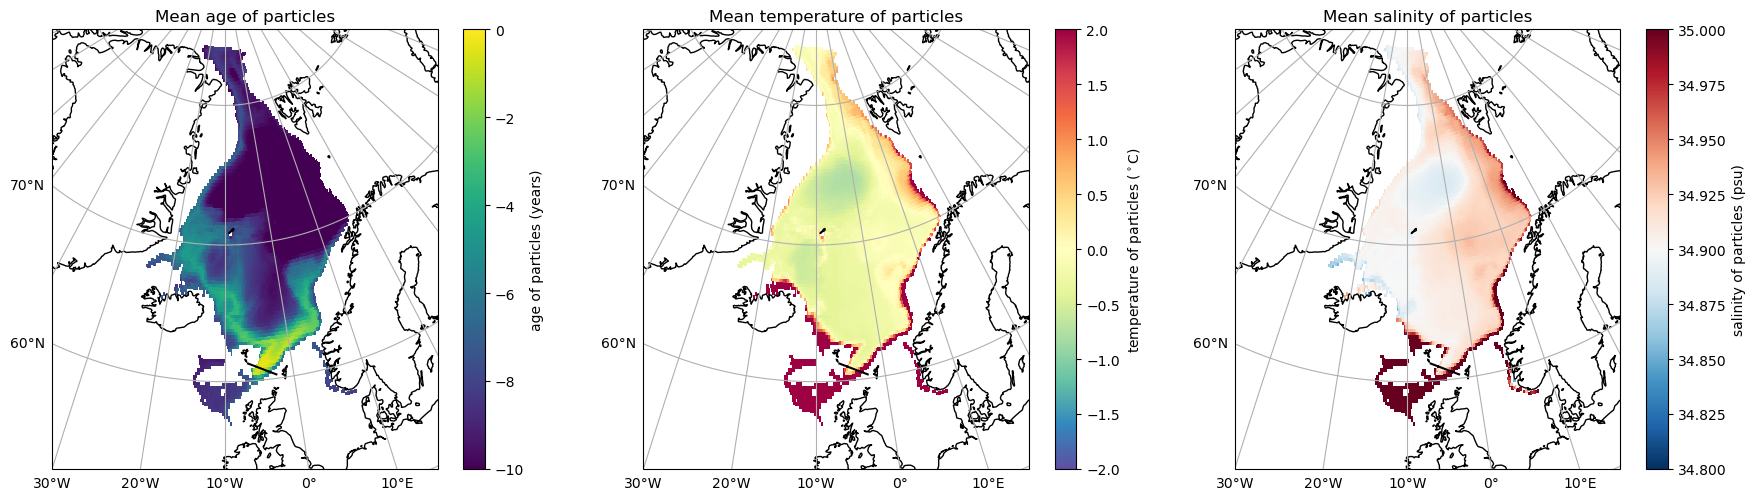

In [39]:

# Create a figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 5), subplot_kw={'projection': ccrs.Orthographic(central_longitude=-10, central_latitude=77)})

# Set the extent for all subplots
for ax in axs:
    ax.set_extent([-30, 15, 51, 85], crs=ccrs.PlateCarree())
    # Plot the bathymetry data on the orthographic map
    pcolormesh = ax.pcolormesh(
        mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, 
        transform=ccrs.PlateCarree(), cmap='binary')

    # Add coastlines
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
    gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

# Plot the first subplot (Mean age of particles)
x1 = axs[0].pcolormesh(heat_map_probability_compute.lon, heat_map_probability_compute.lat, mean_age_cp.T * hours_to_years*mask_0_probability, vmin=-10, vmax=0, cmap='viridis', transform=ccrs.PlateCarree())
cbar1 = plt.colorbar(x1, ax=axs[0], orientation="vertical")
cbar1.set_label(r'age of particles (years)')
axs[0].plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
axs[0].set_title('Mean age of particles')

# Plot the second subplot (Mean temperature of particles)
x2 = axs[1].pcolormesh(heat_map_probability_compute.lon, heat_map_probability_compute.lat, mean_temp_cp.T*mask_0_probability, vmin=-2, vmax=2, cmap='Spectral_r', transform=ccrs.PlateCarree())
cbar2 = plt.colorbar(x2, ax=axs[1], orientation="vertical")
cbar2.set_label(r'temperature of particles ($^\circ$C)')
axs[1].plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
axs[1].set_title('Mean temperature of particles')

# Plot the third subplot (Mean salinity of particles)
x3 = axs[2].pcolormesh(heat_map_probability_compute.lon, heat_map_probability_compute.lat, mean_salt_cp.T*mask_0_probability, vmin=34.8, vmax=35, cmap='RdBu_r', transform=ccrs.PlateCarree())
cbar3 = plt.colorbar(x3, ax=axs[2], orientation="vertical")
cbar3.set_label(r'salinity of particles (psu)')
axs[2].plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
axs[2].set_title('Mean salinity of particles')

# Adjust layout
plt.tight_layout()
plt.show()


## get number of particles crossing east vs west

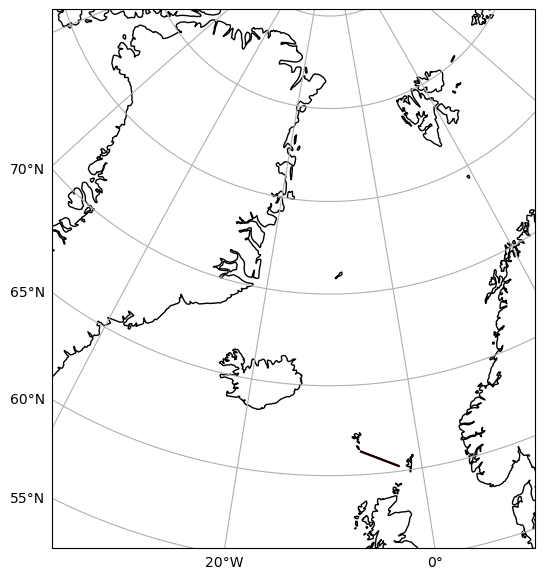

In [31]:
# Create a figure with an orthographic projection
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))

ax.pcolormesh(U_snapshot.nav_lon, U_snapshot.nav_lat, land_mask, transform=ccrs.PlateCarree(), cmap='binary')
plt.plot([-6.5,-2.5],[61.3,60.3],color='red', transform=ccrs.PlateCarree())


plt.plot([-6.5,-2.5],[61.3,60.3],color='k', transform=ccrs.PlateCarree())
#plt.plot([-6.5,-2.5],[61.3,60.3],color='k', transform=ccrs.PlateCarree())
# Add coastlines
ax.coastlines()
# Add gridlines for longitude and latitude
gl = ax.gridlines(draw_labels=True,dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

#plt.savefig('particle_release',dpi=600,bbox_inches='tight',transparent=False)
plt.show()


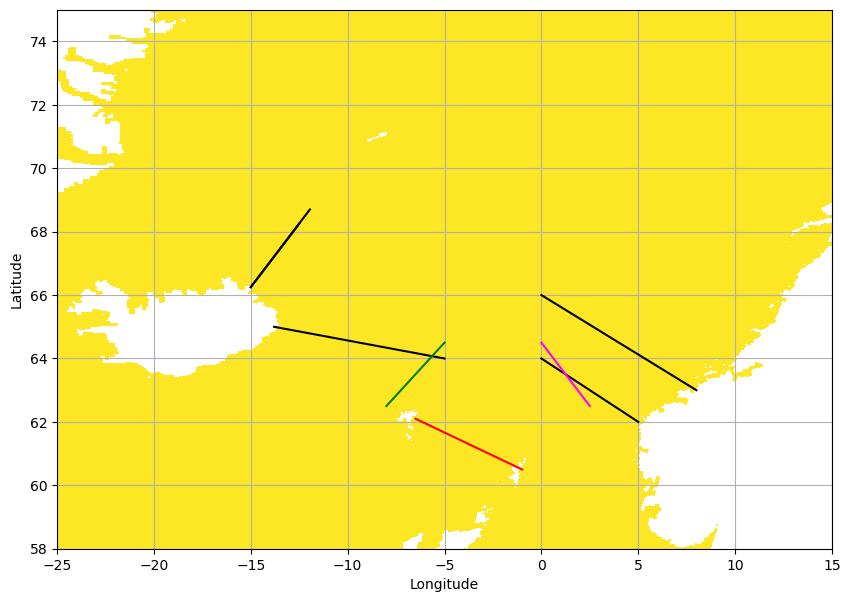

In [42]:
# Create a figure with an orthographic projection
fig, ax = plt.subplots(figsize=(10, 7))

# Plot the land mask
ax.pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, cmap='viridis_r')

# Plot the lines
#ax.plot([-6.5, -2.5], [61.3, 60.3], color='red')

ax.plot([-6.5, -1], [62.1, 60.5], color='red')

ax.plot([-15,-12.5],[66.25,68.25], color='k')

ax.plot([-15,-11.95],[66.25,68.7], color='k')

ax.plot([5,0],[62,64], color='k')

ax.plot([8,0],[63,66], color='k')


ax.plot([-13.8,-5],[65,64], color='k')

# eastern side
ax.plot([-8, -5], [62.5, 64.5], color='green')


# west 
ax.plot([0, 2.5], [64.5, 62.5], color='fuchsia')


# Add gridlines
ax.grid(True)

# Set labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(-25,15)
ax.set_ylim(58,75)
# Show the plot
plt.show()


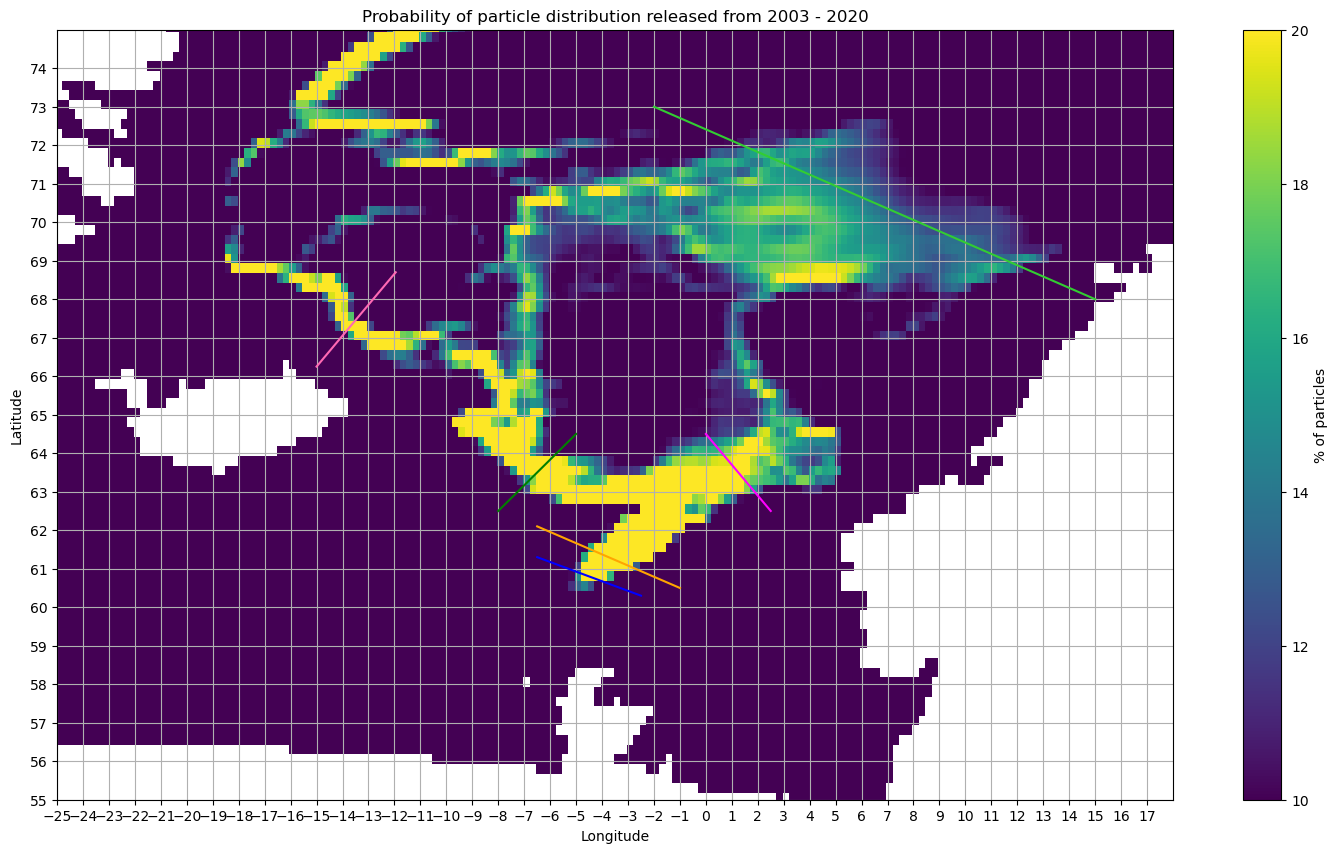

In [40]:
fig, ax = plt.subplots(figsize=(18, 10))

# Plot the bathymetry data
pcolormesh = ax.pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, cmap='binary')

# Plot the heat map probability
x = ax.pcolormesh(heat_map_probability_compute.lon, heat_map_probability_compute.lat, heat_map_probability_compute.where(heat_map_probability_compute!=0), cmap='viridis',
                  vmin=10,vmax=20)

#ax.pcolormesh(mesh_mask.nav_lon, mesh_mask.nav_lat, land_mask, cmap='viridis_r')

cbar = plt.colorbar(x)
cbar.set_label(r'% of particles')



# right near release
ax.plot([-6.5, -1], [62.1, 60.5], color='orange')
# actual release spot
ax.plot([-6.5, -2.5], [61.3, 60.3], color='blue')

# East icelandic current
ax.plot([-15, -11.95], [66.25, 68.7], color='hotpink')

# western side
#ax.plot([-1, 5], [66, 66], color='red')

# western side
ax.plot([-8, -5], [62.5, 64.5], color='green')


# east 
ax.plot([0, 2.5], [64.5, 62.5], color='fuchsia')

# gimsvoy NW side
ax.plot([15, -2], [68, 73], color='limegreen')


ax.set_xlim(-25,18)
ax.set_ylim(55,75)
ax.set_xticks(np.arange(-25, 18, 1))
ax.set_yticks(np.arange(55, 75, 1))
# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Probability of particle distribution released from 2003 - 2020')

# Add grid
ax.grid(True)

plt.show()


In [79]:
# plt.plot([-15, -11.95], [66.25, 68.7], color='hotpink')
# plt.plot([-8, -5], [62.5, 64.5], color='green');

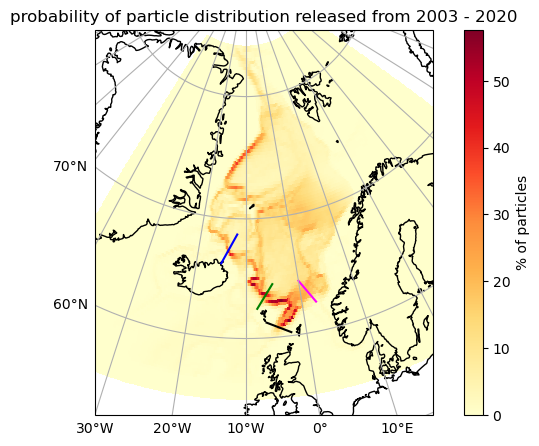

In [79]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
ax.set_extent([-30, 15, 51, 85], crs=ccrs.PlateCarree())
# Plot the bathymetry data on the orthographic map
pcolormesh = ax.pcolormesh(
    mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
# Add color bar for bathymetry
#plt.colorbar(pcolormesh, ax=ax, orientation="vertical", label="bathymetry (m)")

x = ax.pcolormesh(heat_map_probability_compute.lon,heat_map_probability_compute.lat,heat_map_probability_compute,cmap='YlOrRd',transform=ccrs.PlateCarree())
cbar=plt.colorbar(x)
cbar.set_label(r'% of particles')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# EIC
ax.plot([-15,-11.95],[66.25,68.7], color='blue', transform=ccrs.PlateCarree())

# release
#ax.plot([-6.5, -1], [62.1, 60.5], color='red', transform=ccrs.PlateCarree())

# eastern side
ax.plot([-8, -5], [62.5, 64.5], color='green', transform=ccrs.PlateCarree(),label='West')

# west 
ax.plot([0, 2.5], [64.5, 62.5], color='fuchsia', transform=ccrs.PlateCarree(),label='East')

#ax.legend()
# # 
# ax.plot([8,0],[63,66], color='k', transform=ccrs.PlateCarree())


# particle release 

ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
plt.title('probability of particle distribution released from 2003 - 2020')
plt.show()

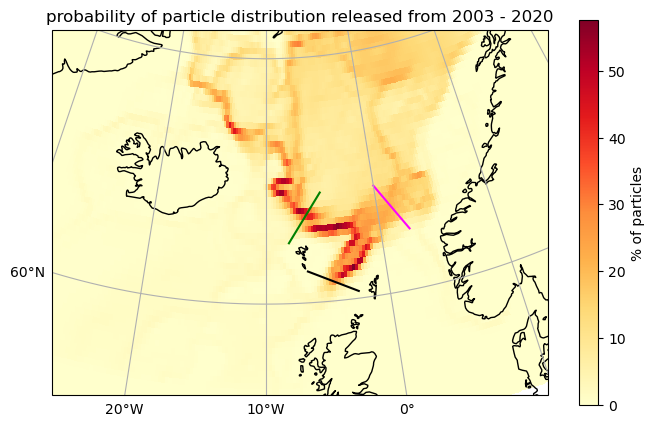

In [69]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
ax.set_extent([-25, 10, 55, 70], crs=ccrs.PlateCarree())
# Plot the bathymetry data on the orthographic map
pcolormesh = ax.pcolormesh(
    mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
# Add color bar for bathymetry
#plt.colorbar(pcolormesh, ax=ax, orientation="vertical", label="bathymetry (m)")

x = ax.pcolormesh(heat_map_probability_compute.lon,heat_map_probability_compute.lat,heat_map_probability_compute,cmap='YlOrRd',transform=ccrs.PlateCarree())
cbar=plt.colorbar(x)
cbar.set_label(r'% of particles')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# EIC
#ax.plot([-15,-11.95],[66.25,68.7], color='red', transform=ccrs.PlateCarree())

# release
#ax.plot([-6.5, -1], [62.1, 60.5], color='red', transform=ccrs.PlateCarree())

# eastern side
ax.plot([-8, -5], [62.5, 64.5], color='green', transform=ccrs.PlateCarree(),label='West')

# west 
ax.plot([0, 2.5], [64.5, 62.5], color='fuchsia', transform=ccrs.PlateCarree(),label='East')

#ax.legend()
# # 
# ax.plot([8,0],[63,66], color='k', transform=ccrs.PlateCarree())


# particle release 

ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
plt.title('probability of particle distribution released from 2003 - 2020')
plt.show()


In [72]:
# TEST CASE, right near release point, should be a high number!

lon_start, lat_start = -6.5, 62.1
lon_end, lat_end = -1, 60.5
crossings = xr.where((ds.lat < lat_start) & (ds.lat > lat_end) & (ds.lon > lon_start) & (ds.lon < lon_end), True, False).any(dim='obs').sum(dim='trajectory')
crossings_cp = crossings.compute()
print('percentage that cross =', ((crossings_cp/ds.trajectory.size)*100).values, '%')

percentage that cross = 95.99773377023885 %


In [74]:
# # western side, green line

# lon_start, lat_start = -8.5, 62.5
# lon_end, lat_end = -5, 64.5
# crossings = xr.where((ds.lat > lat_start) & (ds.lat < lat_end) & (ds.lon > lon_start) & (ds.lon < lon_end), True, False).any(dim='obs').sum(dim='trajectory')
# crossings_cp = crossings.compute()

# print('percentage that cross =', ((crossings_cp/ds.trajectory.size)*100).values, '%')



In [75]:
# # eastern side, pink line

# lon_start, lat_start = 0, 64.5
# lon_end, lat_end = 2.5, 62.5
# crossings = xr.where((ds.lat < lat_start) & (ds.lat > lat_end) & (ds.lon > lon_start) & (ds.lon < lon_end), True, False).any(dim='obs').sum(dim='trajectory')
# crossings_cp = crossings.compute()

# print('percentage that cross =', ((crossings_cp/ds.trajectory.size)*100).values, '%')



In [25]:
# # Calculate overlap (particles that cross both lines)
# overlap_crossings = xr.where(
#     (ds.lat < lat_start_east) & (ds.lat > lat_end_east) & 
#     (ds.lon > lon_start_east) & (ds.lon < lon_end_east) &
#     (ds.lat > lat_start_west) & (ds.lat < lat_end_west) & 
#     (ds.lon > lon_start_west) & (ds.lon < lon_end_west), 
#     True, False
# ).any(dim='obs').sum(dim='trajectory')

# overlap_crossings_cp = overlap_crossings.compute()
# print('Overlap crossings =', overlap_crossings_cp.values)

In [26]:
def count_crossings(section1, section2):
    
    # western side, green line
    crossings_section1 = xr.where(section1, 
        True, False
    ).any(dim='obs').sum(dim='trajectory')

    crossings_section1_cp = crossings_section1.compute()

    # eastern side, pink line

    crossings_section2 = xr.where(section2,
        True, False
    ).any(dim='obs').sum(dim='trajectory')

    crossings_section2_cp = crossings_section2.compute()

    # Total crossings
    total_crossings = crossings_section2_cp + crossings_section1_cp
    print('Total crossings =', total_crossings.values)


    # Calculate percentages relative to total crossings
    if total_crossings > 0:
        percentage_section2 = (crossings_section2_cp / total_crossings) * 100
        percentage_section1 = (crossings_section1_cp / total_crossings) * 100
    else:
        percentage_section2 = 0
        percentage_section1 = 0
    
    print('Percentage of particles that cross section1 line relative to total crossings =', percentage_section1.values, '%')

    print('Percentage of particles that cross section2 line relative to total crossings =', percentage_section2.values, '%')

In [27]:
def check_overlap(section1, section2):
    # Check if particles cross both sections
    cross_section1 = section1.any(dim='obs')
    cross_section2 = section2.any(dim='obs')

    # Calculate overlap (particles that cross both sections)
    overlap_crossings = (cross_section1 & cross_section2).sum(dim='trajectory')

    overlap_crossings_cp = overlap_crossings.compute()
    print('Overlap crossings =', overlap_crossings_cp.values)

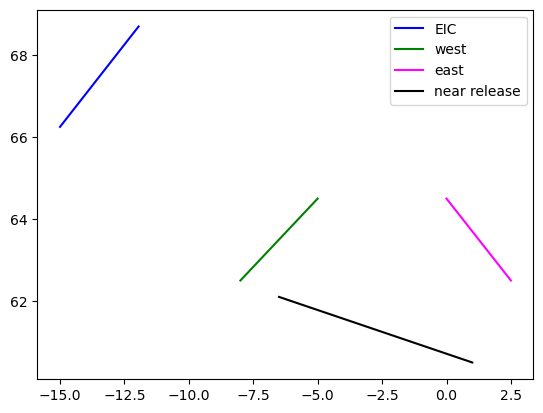

In [28]:
plt.plot([-15, -11.95], [66.25, 68.7], color='blue',label='EIC')
plt.plot([-8, -5], [62.5, 64.5], color='green',label='west')
plt.plot([0, 2.5], [64.5, 62.5], color='fuchsia',label='east')
plt.plot([-6.5, 1], [62.1, 60.5], color='k',label='near release')
plt.legend()
plt.show()

In [29]:
# Define the first section
EIC = (ds.lon > -15) & (ds.lat > 66.25) & (ds.lon < -11.95) & (ds.lat < 68.7) 

# Define the second section
WEST = (ds.lon > -8) & (ds.lat > 62.5) & (ds.lon < -5) & (ds.lat < 64.5)

EAST = (ds.lon > 0) & (ds.lat < 64.5) & (ds.lon < 2.5) & (ds.lat > 62.5) 

# near release
REL = (ds.lon > -6.5) & (ds.lat < 62.1) & (ds.lon < 1) & (ds.lat > 60.5) 


# ax.plot([-6.5, -1], [62.1, 60.5], color='orange') 

In [111]:
count_crossings(EIC, WEST)
check_overlap(EIC, WEST)

Total crossings = 742779
Percentage of particles that cross section1 line relative to total crossings = 39.74991215422084 %
Percentage of particles that cross section2 line relative to total crossings = 60.25008784577916 %
Overlap crossings = 294687


In [35]:
count_crossings(EIC, EAST)
check_overlap(EIC, EAST)

Total crossings = 590186
Percentage of particles that cross section1 line relative to total crossings = 50.02727953560403 %
Percentage of particles that cross section2 line relative to total crossings = 49.97272046439597 %
Overlap crossings = 162841


In [114]:
count_crossings(WEST, EAST)
check_overlap(WEST, EAST)

Total crossings = 742457
Percentage of particles that cross section1 line relative to total crossings = 60.276218016666284 %
Percentage of particles that cross section2 line relative to total crossings = 39.723781983333716 %
Overlap crossings = 267650


In [115]:
count_crossings(EAST, EAST)
check_overlap(EAST, EAST)

Total crossings = 589864
Percentage of particles that cross section1 line relative to total crossings = 50.0 %
Percentage of particles that cross section2 line relative to total crossings = 50.0 %
Overlap crossings = 294932


In [50]:
count_crossings(WEST, WEST)
check_overlap(WEST, WEST)

Total crossings = 895050
Percentage of particles that cross section1 line relative to total crossings = 50.0 %
Percentage of particles that cross section2 line relative to total crossings = 50.0 %
Overlap crossings = 447525


In [216]:
# # set to 1 every time particle crosses that section, set 0 it doesn't
# xr.where((ds.lat > lat_start) & (ds.lat < lat_end) & (ds.lon > lon_start) & (ds.lon < lon_end),1,0).isel(trajectory=10000).plot();

#p

In [210]:
#traj = ds_release.trajectory

In [211]:
#(ds_rel.lat < lat_end_west) & (ds_rel.lat > lat_start_west) & (ds_rel.lon > lon_start_west) & (ds_rel.lon < lon_end_west)

## get the number of particles crossing per release!! 

In [ ]:
# Define the second section
WEST = (ds.lon > -8) & (ds.lat > 62.5) & (ds.lon < -5) & (ds.lat < 64.5)

EAST = (ds.lon > 0) & (ds.lat < 64.5) & (ds.lon < 2.5) & (ds.lat > 62.5) 


In [51]:
EIC = (ds.lon > -15) & (ds.lat > 66.25) & (ds.lon < -11.95) & (ds.lat < 68.7) 


In [52]:
# get the EIC
lat_start_eic = 66.25  # Update to the appropriate latitude for EIC
lat_end_eic = 68.7    # Update to the appropriate latitude for EIC
lon_start_eic = -15.0 # Update to the appropriate longitude for EIC
lon_end_eic = -11.95   # Update to the appropriate longitude for EIC

# Assuming crossings_per_release is already defined
crossings_per_release = {}
for r, ds_release in p.groupby('start_time'):
    print(r, end='')
    ds_rel = ds.sel(trajectory=ds_release.trajectory.values)
    crossings_per_release[r] = int(xr.where(
        (ds_rel.lat > lat_start_eic) & (ds_rel.lat < lat_end_eic) & 
        (ds_rel.lon > lon_start_eic) & (ds_rel.lon < lon_end_eic), 
        True, False
    ).any(dim='obs').sum(dim='trajectory').compute())


2003-01-01T00:00:00.0000000002003-01-06T00:00:00.0000000002003-01-11T00:00:00.0000000002003-01-16T00:00:00.0000000002003-01-21T00:00:00.0000000002003-01-26T00:00:00.0000000002003-01-31T00:00:00.0000000002003-02-05T00:00:00.0000000002003-02-10T00:00:00.0000000002003-02-15T00:00:00.0000000002003-02-20T00:00:00.0000000002003-02-25T00:00:00.0000000002003-03-02T00:00:00.0000000002003-03-07T00:00:00.0000000002003-03-12T00:00:00.0000000002003-03-17T00:00:00.0000000002003-03-22T00:00:00.0000000002003-03-27T00:00:00.0000000002003-04-01T00:00:00.0000000002003-04-06T00:00:00.0000000002003-04-11T00:00:00.0000000002003-04-16T00:00:00.0000000002003-04-21T00:00:00.0000000002003-04-26T00:00:00.0000000002003-05-01T00:00:00.0000000002003-05-06T00:00:00.0000000002003-05-11T00:00:00.0000000002003-05-16T00:00:00.0000000002003-05-21T00:00:00.0000000002003-05-26T00:00:00.0000000002003-05-31T00:00:00.0000000002003-06-05T00:00:00.0000000002003-06-10T00:00:00.0000000002003-06-15T00:00:00.0000000002003-06-20T00:

In [53]:
pd.DataFrame.from_dict(crossings_per_release, orient='index', columns=['crossings_west'])
df = pd.DataFrame.from_dict(crossings_per_release, orient='index', columns=['crossings_west'])
df.to_csv('crossings_per_release_EIC.csv') 

In [ ]:
# get the WEST

# # Assuming crossings_per_release is already defined
# crossings_per_release = {}
# for r, ds_release in p.groupby('start_time'):
#     print(r, end='')
#     ds_rel = ds.sel(trajectory=ds_release.trajectory.values)
#     crossings_per_release[r] = int(xr.where(
#     (ds_rel.lat > lat_start_west) & (ds_rel.lat < lat_end_west) & 
#     (ds_rel.lon > lon_start_west) & (ds_rel.lon < lon_end_west), 
#     True, False
# ).any(dim='obs').sum(dim='trajectory').compute())



2003-01-01T00:00:00.0000000002003-01-06T00:00:00.0000000002003-01-11T00:00:00.0000000002003-01-16T00:00:00.0000000002003-01-21T00:00:00.0000000002003-01-26T00:00:00.0000000002003-01-31T00:00:00.0000000002003-02-05T00:00:00.0000000002003-02-10T00:00:00.0000000002003-02-15T00:00:00.0000000002003-02-20T00:00:00.0000000002003-02-25T00:00:00.0000000002003-03-02T00:00:00.0000000002003-03-07T00:00:00.0000000002003-03-12T00:00:00.0000000002003-03-17T00:00:00.0000000002003-03-22T00:00:00.0000000002003-03-27T00:00:00.0000000002003-04-01T00:00:00.0000000002003-04-06T00:00:00.0000000002003-04-11T00:00:00.0000000002003-04-16T00:00:00.0000000002003-04-21T00:00:00.0000000002003-04-26T00:00:00.0000000002003-05-01T00:00:00.0000000002003-05-06T00:00:00.0000000002003-05-11T00:00:00.0000000002003-05-16T00:00:00.0000000002003-05-21T00:00:00.0000000002003-05-26T00:00:00.0000000002003-05-31T00:00:00.0000000002003-06-05T00:00:00.0000000002003-06-10T00:00:00.0000000002003-06-15T00:00:00.0000000002003-06-20T00:

In [45]:
# get the WEST
lat_start_west = 62.5
lat_end_west = 64.5
lon_start_west = -8
lon_end_west = -5
# Assuming crossings_per_release is already defined
crossings_per_release = {}
for r, ds_release in p.groupby('start_time'):
    print(r, end='')
    ds_rel = ds.sel(trajectory=ds_release.trajectory.values)
    crossings_per_release[r] = int(xr.where(
    (ds_rel.lat > lat_start_west) & (ds_rel.lat < lat_end_west) & 
    (ds_rel.lon > lon_start_west) & (ds_rel.lon < lon_end_west), 
    True, False
).any(dim='obs').sum(dim='trajectory').compute())



2003-01-01T00:00:00.0000000002003-01-06T00:00:00.0000000002003-01-11T00:00:00.0000000002003-01-16T00:00:00.0000000002003-01-21T00:00:00.0000000002003-01-26T00:00:00.0000000002003-01-31T00:00:00.0000000002003-02-05T00:00:00.0000000002003-02-10T00:00:00.0000000002003-02-15T00:00:00.0000000002003-02-20T00:00:00.0000000002003-02-25T00:00:00.0000000002003-03-02T00:00:00.0000000002003-03-07T00:00:00.0000000002003-03-12T00:00:00.0000000002003-03-17T00:00:00.0000000002003-03-22T00:00:00.0000000002003-03-27T00:00:00.0000000002003-04-01T00:00:00.0000000002003-04-06T00:00:00.0000000002003-04-11T00:00:00.0000000002003-04-16T00:00:00.0000000002003-04-21T00:00:00.0000000002003-04-26T00:00:00.0000000002003-05-01T00:00:00.0000000002003-05-06T00:00:00.0000000002003-05-11T00:00:00.0000000002003-05-16T00:00:00.0000000002003-05-21T00:00:00.0000000002003-05-26T00:00:00.0000000002003-05-31T00:00:00.0000000002003-06-05T00:00:00.0000000002003-06-10T00:00:00.0000000002003-06-15T00:00:00.0000000002003-06-20T00:

In [48]:
#crossings_per_release

In [71]:
# %%time

# # Assuming crossings_per_release is already defined
# crossings_per_release = {}
# for r, ds_release in p.groupby('start_time'):
#     print(r, end='')
#     ds_rel = ds.sel(trajectory=ds_release.trajectory.values)
#     crossings_per_release[r] = int(xr.where(WEST, 
#     True, False
# ).any(dim='obs').sum(dim='trajectory').compute())



In [30]:
def crossings_per_release(section):
    # Assuming crossings_per_release is already defined
    crossings_per_release = {}
    for r, ds_release in p.groupby('start_time'):
        print(r, end='')
        ds_rel = ds.sel(trajectory=ds_release.trajectory.values)
        crossings_per_release[r] = int(xr.where(section, 
        True, False
    ).any(dim='obs').sum(dim='trajectory').compute())
    return crossings_per_release

In [171]:
# # Assuming crossings_per_release is already defined
# crossings_per_release_EAST = {}
# for r, ds_release in p.groupby('start_time'):
#     print(r, end='')
#     ds_rel = ds.sel(trajectory=ds_release.trajectory.values)
#     crossings_per_release_EAST[r] = int(xr.where(
#     (ds_rel.lat < lat_start_east) & (ds_rel.lat > lat_end_east) & 
#     (ds_rel.lon > lon_start_east) & (ds_rel.lon < lon_end_east), 
#     True, False
# ).any(dim='obs').sum(dim='trajectory').compute())


2003-01-01T00:00:00.0000000002003-01-06T00:00:00.0000000002003-01-11T00:00:00.0000000002003-01-16T00:00:00.0000000002003-01-21T00:00:00.0000000002003-01-26T00:00:00.0000000002003-01-31T00:00:00.0000000002003-02-05T00:00:00.0000000002003-02-10T00:00:00.0000000002003-02-15T00:00:00.0000000002003-02-20T00:00:00.0000000002003-02-25T00:00:00.0000000002003-03-02T00:00:00.0000000002003-03-07T00:00:00.0000000002003-03-12T00:00:00.0000000002003-03-17T00:00:00.0000000002003-03-22T00:00:00.0000000002003-03-27T00:00:00.0000000002003-04-01T00:00:00.0000000002003-04-06T00:00:00.0000000002003-04-11T00:00:00.0000000002003-04-16T00:00:00.0000000002003-04-21T00:00:00.0000000002003-04-26T00:00:00.0000000002003-05-01T00:00:00.0000000002003-05-06T00:00:00.0000000002003-05-11T00:00:00.0000000002003-05-16T00:00:00.0000000002003-05-21T00:00:00.0000000002003-05-26T00:00:00.0000000002003-05-31T00:00:00.0000000002003-06-05T00:00:00.0000000002003-06-10T00:00:00.0000000002003-06-15T00:00:00.0000000002003-06-20T00:

In [172]:
# pd.DataFrame.from_dict(crossings_per_release_EAST, orient='index', columns=['crossings_west'])
# df = pd.DataFrame.from_dict(crossings_per_release_EAST, orient='index', columns=['crossings_west'])
# df.to_csv('crossings_per_release_EAST.csv') 

In [149]:
# pd.DataFrame.from_dict(crossings_per_release, orient='index', columns=['crossings_west'])
# df = pd.DataFrame.from_dict(crossings_per_release, orient='index', columns=['crossings_west'])
# df.to_csv('crossings_per_release_WEST.csv') 

In [35]:
def read_csv(file):
    crossings_per_release = pd.read_csv(file)
    crossings_per_release = crossings_per_release.set_index('Unnamed: 0')
    crossings_per_release.index = pd.to_datetime(crossings_per_release.index)
    crossings_per_release = crossings_per_release.to_xarray()
    crossings_per_release = crossings_per_release.rename({'Unnamed: 0': 'time'})
    return crossings_per_release


In [54]:
crossings_per_release_WEST = read_csv('crossings_per_release_WEST.csv')
crossings_per_release_EAST = read_csv('crossings_per_release_EAST.csv')
crossings_per_release_EIC = read_csv('crossings_per_release_EIC.csv')

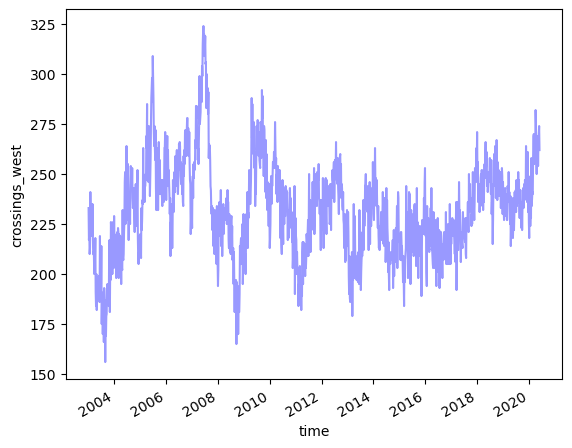

In [55]:
crossings_per_release_EIC.crossings_west.plot(color='blue', alpha=0.4,label='EIC')
#crossings_per_release_EIC.crossings_west.rolling(time=30).mean().plot(color='blue', label='EIC (30-day MA)');

In [56]:
#crossings_per_release_WEST.crossings_west.plot(color='green', alpha=0.4,label='WEST')
#crossings_per_release_WEST_11_2.crossings_west.plot(color='k', alpha=0.4,label='WEST')

In [60]:
# crossings_per_release_EAST = pd.read_csv('crossings_per_release_EAST.csv')
# crossings_per_release_EAST = crossings_per_release_EAST.set_index('Unnamed: 0')
# crossings_per_release_EAST.index = pd.to_datetime(crossings_per_release_EAST.index)
# crossings_per_release_EAST = crossings_per_release_EAST.to_xarray()
# crossings_per_release_EAST = crossings_per_release_EAST.rename({'Unnamed: 0': 'time'})

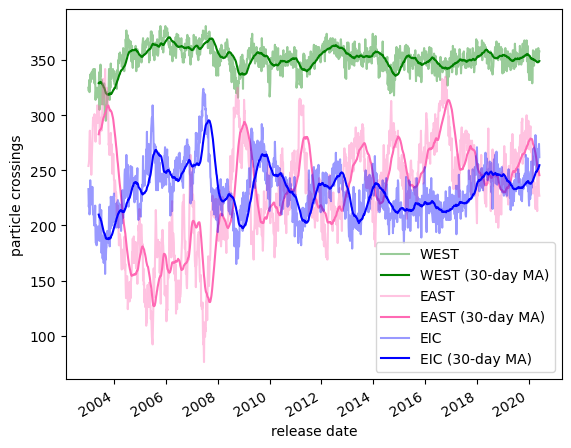

In [57]:
crossings_per_release_WEST.crossings_west.plot(color='green', alpha=0.4,label='WEST')
crossings_per_release_WEST.crossings_west.rolling(time=30).mean(dim='time').plot(color='green', label='WEST (30-day MA)')
crossings_per_release_EAST.crossings_west.plot(color='hotpink', alpha=0.4,label='EAST')
crossings_per_release_EAST.crossings_west.rolling(time=30).mean().plot(color='hotpink', label='EAST (30-day MA)')
crossings_per_release_EIC.crossings_west.plot(color='blue', alpha=0.4,label='EIC')
crossings_per_release_EIC.crossings_west.rolling(time=30).mean().plot(color='blue', label='EIC (30-day MA)')
plt.xlabel('release date')
plt.ylabel('particle crossings')
plt.legend()
plt.show()

In [191]:
# # annual sum
# # Convert the index to a pandas datetime index if it's not already
# crossings_per_release_WEST = crossings_per_release_WEST.to_dataframe().reset_index()
# crossings_per_release_EAST = crossings_per_release_EAST.to_dataframe().reset_index()

# # Group by year and sum the crossings
# crossings_per_release_WEST['year'] = crossings_per_release_WEST['Unnamed: 0'].dt.year
# crossings_per_release_EAST['year'] = crossings_per_release_EAST['Unnamed: 0'].dt.year

# crossings_per_year_WEST = crossings_per_release_WEST.groupby('year')['crossings_west'].sum()
# crossings_per_year_EAST = crossings_per_release_EAST.groupby('year')['crossings_west'].sum()

# # Plot the results
# crossings_per_year_WEST.plot(label='West Crossings')
# crossings_per_year_EAST.plot(label='East Crossings')
# plt.xlabel('Year')
# plt.ylabel('Total Crossings')
# plt.legend()
# plt.show()

# get the mean maps of age, S, T, rho bsaed on contribution from east versus west

In [ ]:
WEST_mask = WEST.any(dim='obs').compute()

crossing_WEST = ds.where(WEST_mask, drop=True)

In [69]:
EAST_mask = EAST.any(dim='obs').compute()

crossing_EAST = ds.where(EAST_mask, drop=True)

In [108]:
# Count total trajectories (assuming 'trajectory' is the dimension for trajectories)
total_trajectories = ds.trajectory.size

# Count trajectories crossing EAST
crossing_EAST_count = EAST_mask.sum()

# Calculate the percentage of trajectories crossing EAST
percentage_crossing_EAST = (crossing_EAST_count / total_trajectories) * 100

In [90]:
#crossing_EAST.trajectory.size/ds.trajectory.size
#crossing_WEST.trajectory.size/ds.trajectory.size

In [94]:
lon_rechunk_WEST = rechunk_for_hist(crossing_WEST['lon'])
lat_rechunk_WEST = rechunk_for_hist(crossing_WEST['lat'])

lon_rechunk_EAST = rechunk_for_hist(crossing_EAST['lon'])
lat_rechunk_EAST = rechunk_for_hist(crossing_EAST['lat'])

In [96]:
mean_salt_WEST = get_mean_maps(crossing_WEST.salt,lon_rechunk_WEST,lat_rechunk_WEST)

mean_age_WEST = get_mean_maps(crossing_WEST.age,lon_rechunk_WEST,lat_rechunk_WEST)

mean_temp_WEST = get_mean_maps(crossing_WEST.temp,lon_rechunk_WEST,lat_rechunk_WEST)


In [95]:
mean_salt_EAST = get_mean_maps(crossing_EAST.salt, lon_rechunk_EAST, lat_rechunk_EAST)

mean_age_EAST = get_mean_maps(crossing_EAST.age, lon_rechunk_EAST, lat_rechunk_EAST)

mean_temp_EAST = get_mean_maps(crossing_EAST.temp, lon_rechunk_EAST, lat_rechunk_EAST)


In [97]:
mean_age_WEST_cp = mean_age_WEST.compute()
mean_age_EAST_cp = mean_age_EAST.compute()

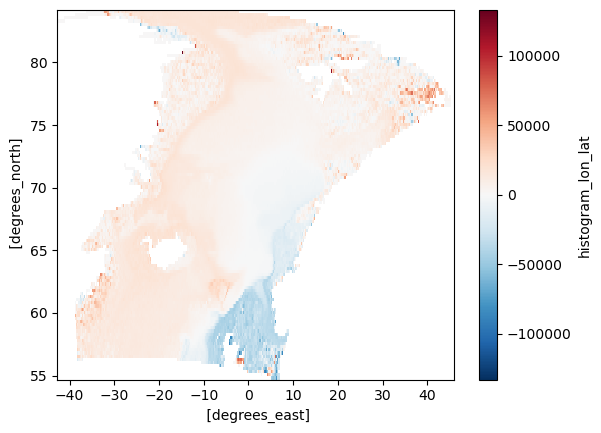

In [102]:
(mean_age_WEST_cp.T-mean_age_EAST_cp.T).plot();

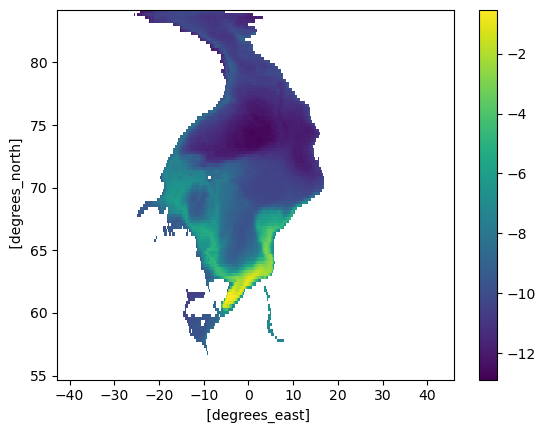

In [106]:
(mean_age_EAST_cp.T*hours_to_years*mask_0_probability).plot();

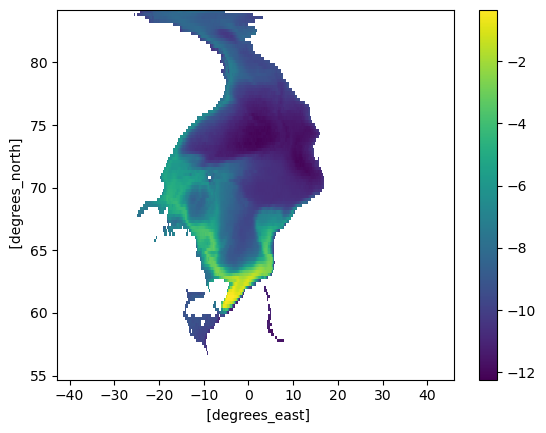

In [107]:
(mean_age_WEST_cp.T*hours_to_years*mask_0_probability).plot();

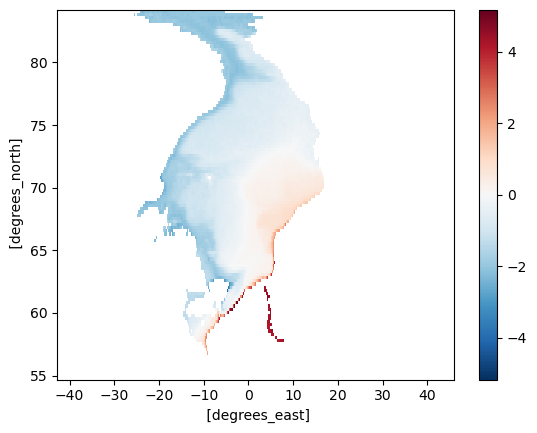

In [114]:
((mean_age_EAST_cp.T*hours_to_years*mask_0_probability) - (mean_age_WEST_cp.T*hours_to_years*mask_0_probability)).plot();